In [0]:
!pip install catboost
!pip install tsfresh
!pip install xgboost
!pip install shap
!pip install lightgbm

    100% |████████████████████████████████| 55.5MB 821kB/s 
    100% |████████████████████████████████| 122kB 6.2MB/s 
    100% |████████████████████████████████| 522kB 25.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/6d/e1/ce/f4ee2fa420cc6b940123c64992b81047816d0a9fad6b879325
Successfully built tornado
google-colab 0.0.1a1 has requirement tornado~=4.5.0, but you'll have tornado 5.1.1 which is incompatible.
  Found existing installation: tornado 4.5.3
    Uninstalling tornado-4.5.3:
      Successfully uninstalled tornado-4.5.3


    100% |████████████████████████████████| 225kB 12.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/bf/26/bd/912db1314f1cef0171d9b7f128dd01e8b8c92ed8d0062e632d
Successfully built shap


In [0]:
# The essentials
import pandas as pd
import numpy as np

from collections import defaultdict

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Progress bars
from tqdm import tqdm

# Access our Google Drive
from google.colab import drive

# Gradient Boosting
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import KFold, GridSearchCV

from collections import defaultdict, Counter
from scipy.stats import norm

import datetime

import glob

import shap

In [0]:
drive.mount('/content/drive', force_remount=True)
!ls "/content/drive/My Drive/Rinse Over Run"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
20178.png
20451.png
20899.png
22112.png
22369.png
22414.png
22487.png
23011.png
23142.png
23599.png
23872.png
24804.png
24845.png
24872.png
25129.png
25908.png
25983.png
26270.png
27115.png
27243.png
27346.png
27366.png
27418.png
27508.png
all_train_preds_per_phase.p
baseline_features_with_preds_per_phase.csv
baseline_model_per_nunique_phases.csv
better_prev_object_id_per_10.csv
dtw_distances_3.p
extended_phase_predictors.csv
final_phase_labels_15_14.csv
final

In [0]:
def custom_mape(approxes, targets):
    return np.mean(np.abs(np.subtract(approxes, targets)) / np.maximum(np.abs(targets), 290000))


def get_corr_features(X):
  row_idx, col_idx = np.where(X.corr() == 1)
  self_corr = set([(i, i) for i in range(X.shape[1])])
  return set(list(zip(row_idx, col_idx))) - self_corr 

def get_uncorr_features(data):
  X_train_corr = data.copy()
  correlated_features = get_corr_features(X_train_corr)
  
  corr_cols = set()
  for row_idx, col_idx in correlated_features:
    corr_cols.add(row_idx)
    corr_cols.add(col_idx)
  
  uncorr_cols = list(set(X_train_corr.columns) - set(X_train_corr.columns[list(corr_cols)]))
   
  col_mask = [False]*X_train_corr.shape[1]
  for col in corr_cols:
    col_mask[col] = True
  X_train_corr = X_train_corr.loc[:, col_mask]
  
  correlated_features = get_corr_features(X_train_corr)
  
  while correlated_features:
    print('{} correlated feature pairs left...'.format(len(correlated_features)))
    corr_row, corr_col = correlated_features.pop()
    col_mask = [True]*X_train_corr.shape[1]
    col_mask[corr_row] = False
    X_train_corr = X_train_corr.loc[:, col_mask]
    correlated_features = get_corr_features(X_train_corr)
  return list(set(list(X_train_corr.columns) + uncorr_cols))

def remove_features(data, target, p_val=0.25):
  single_cols = list(data.columns[data.nunique() == 1])
  
  uncorr_cols = get_uncorr_features(data)
  corr_cols = list(set(data.columns) - set(uncorr_cols))
  
  return list(set(single_cols + corr_cols))

In [0]:
class MAPEMetric(object):
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, targets, weight):
        return custom_mape(np.exp(approxes), np.exp(targets)), len(targets)


def mape_xgb(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y)
    yhat = np.exp(yhat)
    error = np.mean(np.abs(yhat - y)/np.maximum(290000, y))
    return "mape", error
  
def mapeobj(preds,dtrain):
    # gaps = dtrain.get_label()
    gaps = dtrain
    grad = np.sign(preds-gaps)/np.maximum(np.log(290000), gaps)
    hess = 1/gaps
    grad[(gaps==0)] = 0
    hess[(gaps==0)] = 0
    return -grad,hess  
  
def mape_lgbm(y, yhat):
    y = np.exp(y)
    yhat = np.exp(yhat)
    error = np.mean(np.abs(yhat - y)/np.maximum(290000, y))
    return "mape", error, False
  
def mapeobj_lgbm(y_true, y_pred):
    # gaps = dtrain.get_label()
    grad = np.sign(y_pred-y_true)/np.maximum(np.log(290000), y_true)
    hess = 1 / y_true
    grad[(y_true==0)] = 0
    hess[(y_true==0)] = 0
    return grad, hess  

def fit_lgbm(X_train, y_train, X_test, processes=None):
  train_idx = np.random.choice(X_train.index, replace=False, size=int(0.95 * len(X_train)))
  val_idx = list(set(X_train.index) - set(train_idx))

  X_val = X_train.loc[val_idx, :]
  y_val = y_train.loc[val_idx]
  X_train = X_train.loc[train_idx, :]
  y_train = y_train.loc[train_idx]

  cat = LGBMRegressor(n_estimators=100000, objective='mape')
  cat.fit(X_train.values, y_train.values, eval_set=(X_val.values, y_val.values), 
          early_stopping_rounds=100, verbose=50, eval_metric=mape_lgbm)
  
  best_nr_trees = cat.best_iteration_
    
  predictions = cat.predict(X_test, num_iteration=best_nr_trees)

  explainer = shap.TreeExplainer(cat)
  shap_values = explainer.shap_values(pd.concat([X_train, X_val, X_test]).values)

  plt.figure()
  shap.summary_plot(shap_values, pd.concat([X_train, X_val, X_test]).values, max_display=30, 
                    auto_size_plot=True, show=False, color_bar=False)
  plt.show()
  
  return predictions

def fit_cat(X_train, y_train, X_test, processes=None):
  train_idx = np.random.choice(X_train.index, replace=False, size=int(0.95 * len(X_train)))
  val_idx = list(set(X_train.index) - set(train_idx))

  X_val = X_train.loc[val_idx, :]
  y_val = y_train.loc[val_idx]
  X_train = X_train.loc[train_idx, :]
  y_train = y_train.loc[train_idx]
  
  cat = CatBoostRegressor(iterations=100000, od_type='Iter', od_wait=100, 
                          learning_rate=0.33,
                          loss_function='MAPE', eval_metric=MAPEMetric(), task_type='CPU')
  cat.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=50)


  predictions = cat.predict(X_test)

  explainer = shap.TreeExplainer(cat)
  shap_values = explainer.shap_values(pd.concat([X_train, X_val, X_test]).values)

  plt.figure()
  shap.summary_plot(shap_values, pd.concat([X_train, X_val, X_test]).values, max_display=30, 
                    auto_size_plot=True, show=False, color_bar=False)
  plt.show()
  
  return predictions

def fit_xgb(X_train, y_train, X_test, processes=None):
  train_idx = np.random.choice(X_train.index, replace=False, size=int(0.95 * len(X_train)))
  val_idx = list(set(X_train.index) - set(train_idx))

  X_val = X_train.loc[val_idx, :]
  y_val = y_train.loc[val_idx]
  X_train = X_train.loc[train_idx, :]
  y_train = y_train.loc[train_idx]
  
  xgb = XGBRegressor(n_estimators=100000, objective=mapeobj)
  xgb.fit(X_train.values, y_train.values, eval_set=[(X_val.values, y_val.values)], 
          early_stopping_rounds=100, verbose=50, eval_metric=mape_xgb)
  
  best_n_trees = xgb.best_ntree_limit
  
  predictions = xgb.predict(X_test.values, ntree_limit=best_n_trees)

#   explainer = shap.TreeExplainer(xgb)
#   shap_values = explainer.shap_values(pd.concat([X_train, X_val, X_test]).values)

#   plt.figure()
#   shap.summary_plot(shap_values, pd.concat([X_train, X_val, X_test]), max_display=30, 
#                     auto_size_plot=True, show=False, color_bar=False)
#   plt.show()
  
  return predictions

def get_prev_predictions(data, submission_file, col): 
  labels = pd.read_csv(submission_file, index_col=0)
  machines = set(data['object_id'])
  vectors = []
  for machine in machines:
    machine_processes = train_df[train_df['object_id'] == machine].sort_values(by='timestamp')['process_id'].unique()
    machine_processes = list(set(machine_processes).intersection(set(labels.index)))
    for process_ix, process in enumerate(machine_processes):
      mu = labels.loc[machine_processes[:process_ix]][col].mean()
      diff = labels.loc[process][col] - mu
      vectors.append([process, mu, diff])
      
  prev_df = pd.DataFrame(vectors, columns=['process_id', 'running_average_{}'.format(col), 'diff_{}'.format(col)])
  prev_df = prev_df.set_index('process_id', drop=True)
  
  return prev_df

In [0]:
train_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_values.csv', index_col=0, parse_dates=['timestamp'])
test_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/test_values.csv', index_col=0, parse_dates=['timestamp'])
df = pd.concat([train_df, test_df])

(3734, 1081) (227, 1081)
{'xgb_return_turbidity_pred', 'xgb_pred', 'xgb_return_flow_pred', 'lgbm_return_flow_pred'}
1176 correlated feature pairs left...
1134 correlated feature pairs left...
1094 correlated feature pairs left...
1056 correlated feature pairs left...
1020 correlated feature pairs left...
986 correlated feature pairs left...
984 correlated feature pairs left...
942 correlated feature pairs left...
902 correlated feature pairs left...
870 correlated feature pairs left...
832 correlated feature pairs left...
796 correlated feature pairs left...
766 correlated feature pairs left...
732 correlated feature pairs left...
706 correlated feature pairs left...
674 correlated feature pairs left...
644 correlated feature pairs left...
616 correlated feature pairs left...
588 correlated feature pairs left...
564 correlated feature pairs left...
542 correlated feature pairs left...
516 correlated feature pairs left...
492 correlated feature pairs left...
466 correlated feature pairs

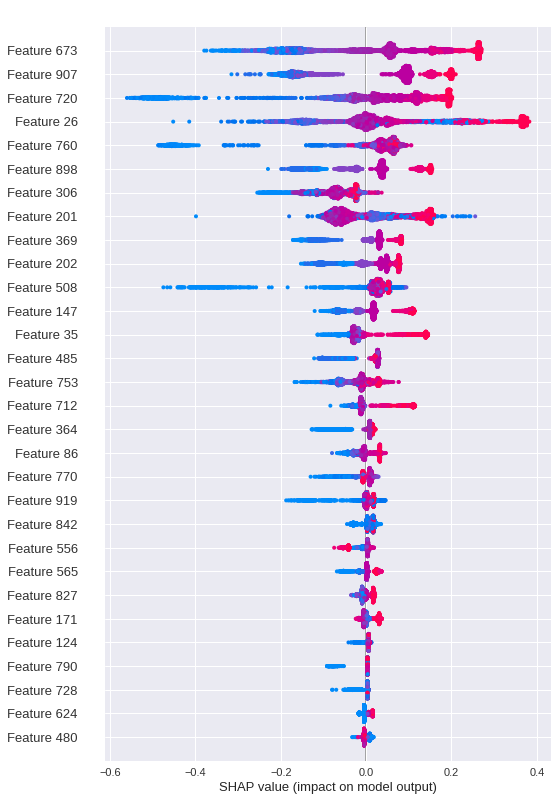

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's mape: 0.0375424	valid_0's mape: 0.30845
[100]	valid_0's mape: 0.0375155	valid_0's mape: 0.309962
Early stopping, best iteration is:
[49]	valid_0's mape: 0.0375277	valid_0's mape: 0.30835


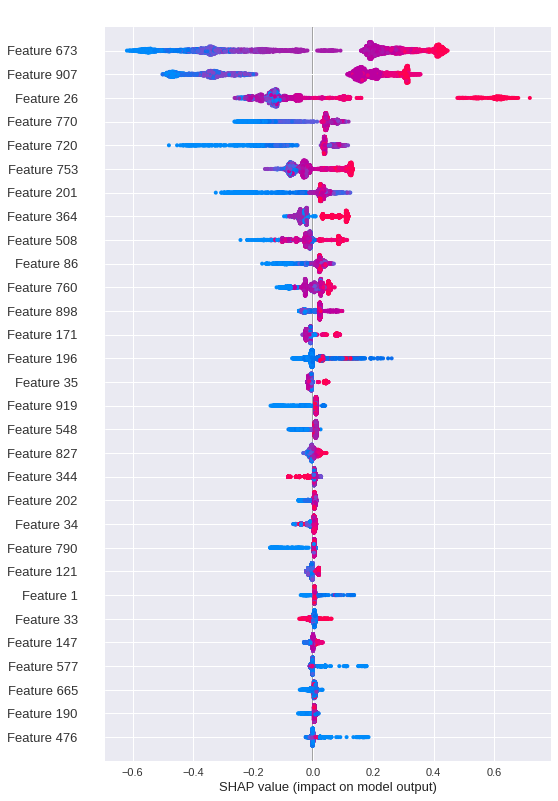

(3731, 1299) (679, 1299)
{'turbidity_return_xgb_pred', 'xgb_return_flow_pred', 'lgbm_return_flow_pred'}
1058 correlated feature pairs left...
1016 correlated feature pairs left...
974 correlated feature pairs left...
934 correlated feature pairs left...
896 correlated feature pairs left...
860 correlated feature pairs left...
858 correlated feature pairs left...
818 correlated feature pairs left...
780 correlated feature pairs left...
746 correlated feature pairs left...
714 correlated feature pairs left...
712 correlated feature pairs left...
682 correlated feature pairs left...
654 correlated feature pairs left...
618 correlated feature pairs left...
592 correlated feature pairs left...
558 correlated feature pairs left...
526 correlated feature pairs left...
496 correlated feature pairs left...
494 correlated feature pairs left...
466 correlated feature pairs left...
440 correlated feature pairs left...
416 correlated feature pairs left...
392 correlated feature pairs left...
370 co

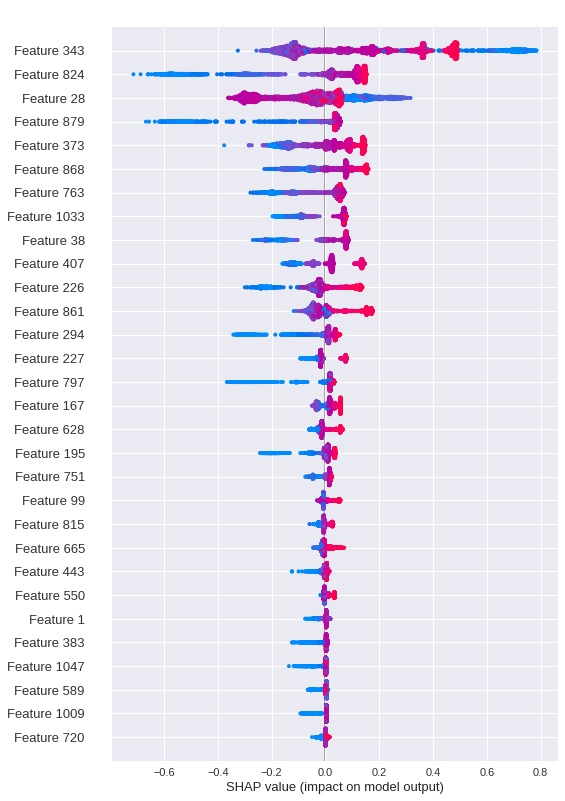

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's mape: 0.0304692	valid_0's mape: 0.252151
[100]	valid_0's mape: 0.0303845	valid_0's mape: 0.252021
[150]	valid_0's mape: 0.0303427	valid_0's mape: 0.252087
Early stopping, best iteration is:
[60]	valid_0's mape: 0.0303559	valid_0's mape: 0.250834


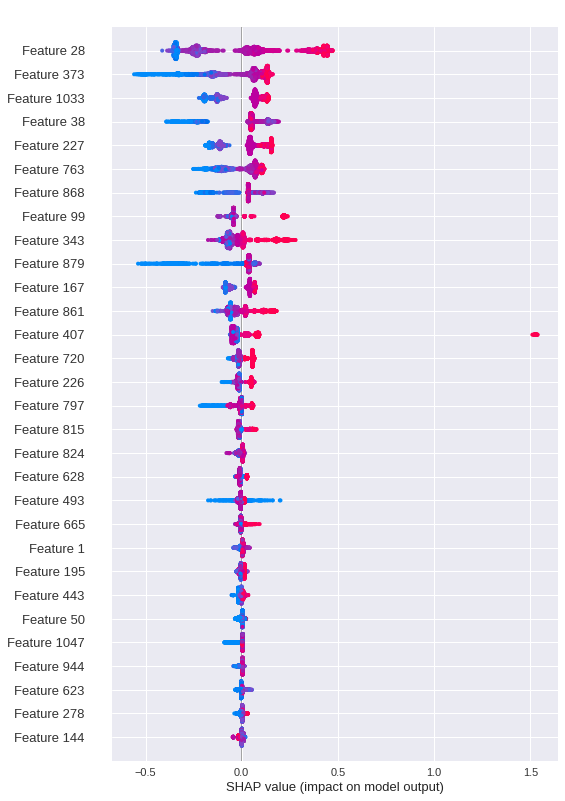

(3726, 1299) (670, 1299)
{'turbidity_return_xgb_pred', 'xgb_return_flow_pred', 'lgbm_return_flow_pred'}
1004 correlated feature pairs left...
1000 correlated feature pairs left...
998 correlated feature pairs left...
956 correlated feature pairs left...
916 correlated feature pairs left...
878 correlated feature pairs left...
842 correlated feature pairs left...
840 correlated feature pairs left...
800 correlated feature pairs left...
762 correlated feature pairs left...
728 correlated feature pairs left...
696 correlated feature pairs left...
694 correlated feature pairs left...
658 correlated feature pairs left...
656 correlated feature pairs left...
622 correlated feature pairs left...
620 correlated feature pairs left...
588 correlated feature pairs left...
558 correlated feature pairs left...
530 correlated feature pairs left...
504 correlated feature pairs left...
474 correlated feature pairs left...
450 correlated feature pairs left...
428 correlated feature pairs left...
400 co

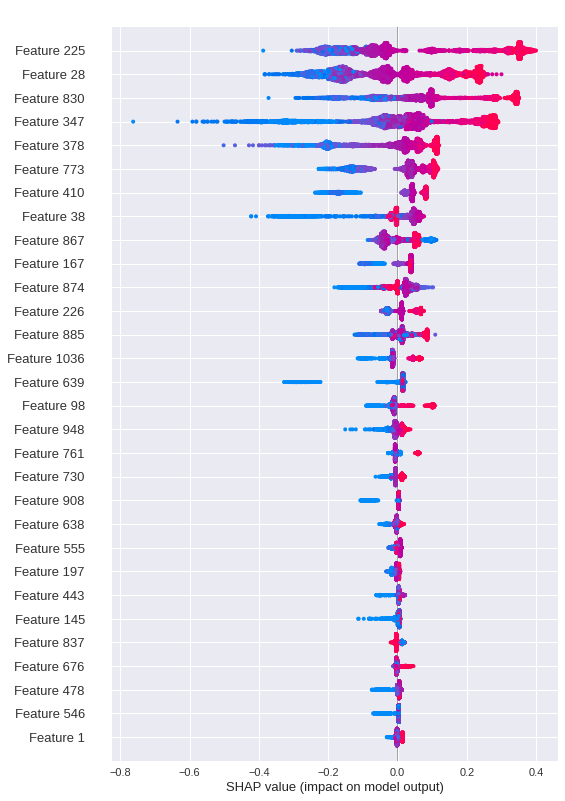

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's mape: 0.0261102	valid_0's mape: 0.229272
[100]	valid_0's mape: 0.0260254	valid_0's mape: 0.229535
Early stopping, best iteration is:
[41]	valid_0's mape: 0.0261489	valid_0's mape: 0.228181


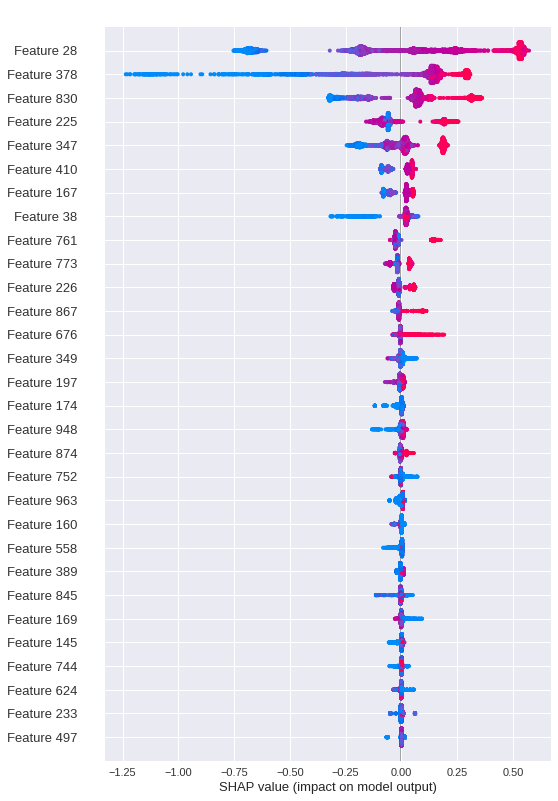

(3726, 1299) (671, 1299)
{'xgb_return_flow_pred', 'lgbm_return_flow_pred'}
958 correlated feature pairs left...
916 correlated feature pairs left...
876 correlated feature pairs left...
838 correlated feature pairs left...
802 correlated feature pairs left...
764 correlated feature pairs left...
730 correlated feature pairs left...
698 correlated feature pairs left...
662 correlated feature pairs left...
628 correlated feature pairs left...
626 correlated feature pairs left...
594 correlated feature pairs left...
564 correlated feature pairs left...
534 correlated feature pairs left...
506 correlated feature pairs left...
480 correlated feature pairs left...
452 correlated feature pairs left...
428 correlated feature pairs left...
402 correlated feature pairs left...
400 correlated feature pairs left...
378 correlated feature pairs left...
354 correlated feature pairs left...
332 correlated feature pairs left...
312 correlated feature pairs left...
294 correlated feature pairs left...


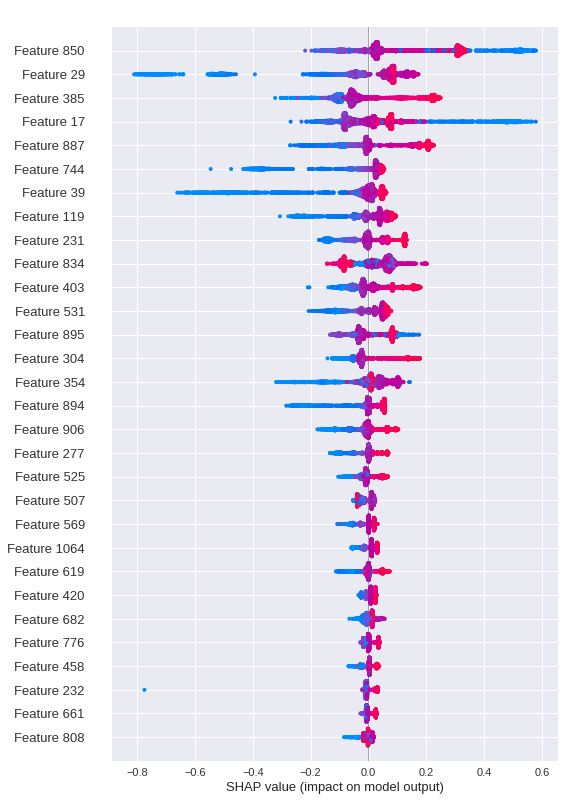

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's mape: 0.0312472	valid_0's mape: 0.323526
[100]	valid_0's mape: 0.0303355	valid_0's mape: 0.3254
Early stopping, best iteration is:
[36]	valid_0's mape: 0.0327121	valid_0's mape: 0.313136


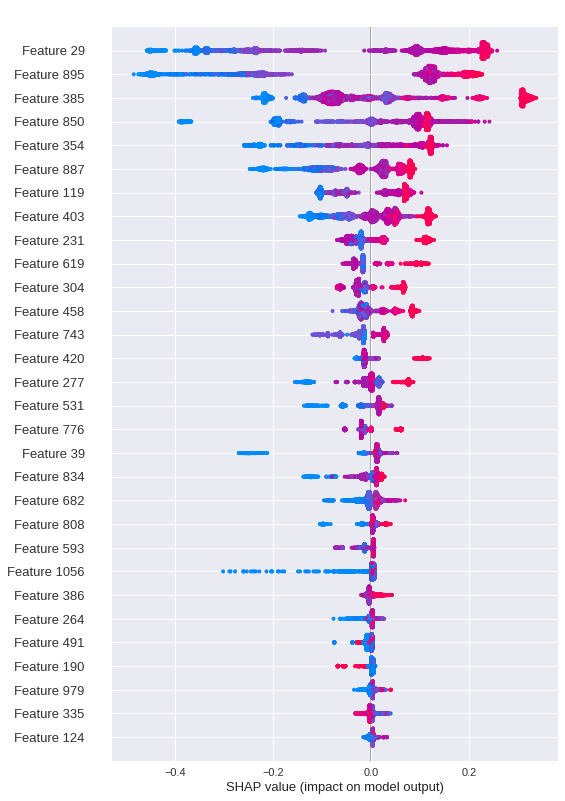

(1012, 1286) (503, 1286)
{'turbidity_return_xgb_pred', 'xgb_return_flow_pred', 'lgbm_return_flow_pred'}
1100 correlated feature pairs left...
1058 correlated feature pairs left...
1018 correlated feature pairs left...
976 correlated feature pairs left...
938 correlated feature pairs left...
902 correlated feature pairs left...
868 correlated feature pairs left...
836 correlated feature pairs left...
806 correlated feature pairs left...
796 correlated feature pairs left...
788 correlated feature pairs left...
748 correlated feature pairs left...
746 correlated feature pairs left...
708 correlated feature pairs left...
702 correlated feature pairs left...
674 correlated feature pairs left...
648 correlated feature pairs left...
612 correlated feature pairs left...
610 correlated feature pairs left...
576 correlated feature pairs left...
574 correlated feature pairs left...
550 correlated feature pairs left...
528 correlated feature pairs left...
496 correlated feature pairs left...
494 c

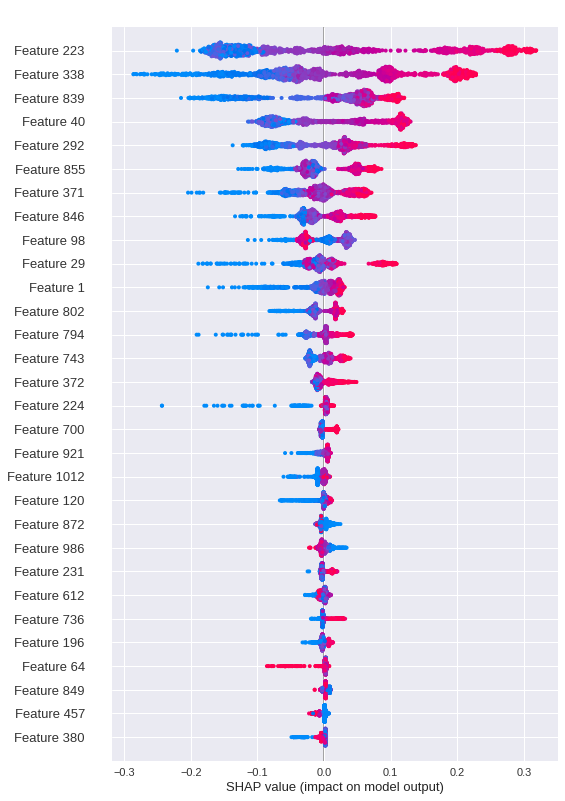

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's mape: 0.0215562	valid_0's mape: 0.244938
[100]	valid_0's mape: 0.0213129	valid_0's mape: 0.24287
[150]	valid_0's mape: 0.0212411	valid_0's mape: 0.24299
Early stopping, best iteration is:
[79]	valid_0's mape: 0.0212352	valid_0's mape: 0.240855


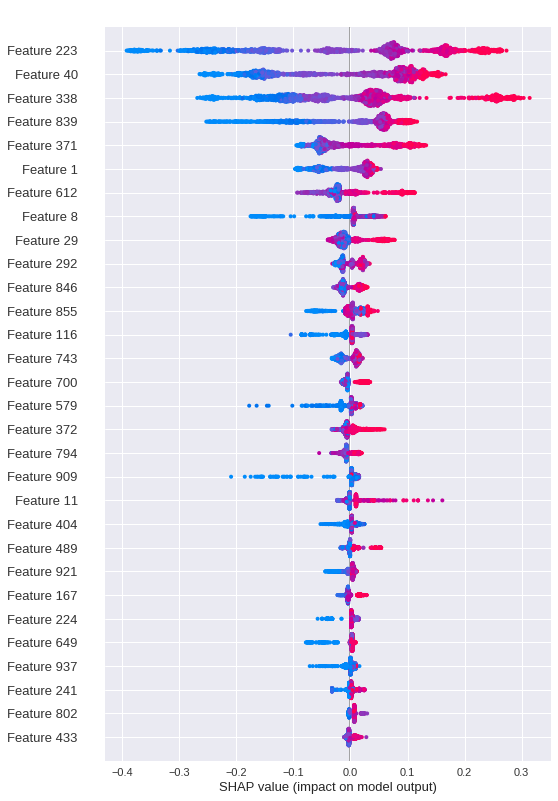

In [0]:
def fitimport warnings; warnings.filterwarnings('ignore')

from sklearn.manifold import TSNE

combinations_per_recipe = {
    3: [3],  # 1, 2, 
    9: [8],
    15: [1, 3, 7, 15]#, 1, 3, 7]
}

weights = {
    (3, 1): 0.0219,
    (3, 2): 0.0064,
    (3, 3): 0.1695,
    (9, 8): 0.0411,
    (15, 1): 0.0765,
    (15, 2): 0.0013,
    (15, 3): 0.2289,
    (15, 6): 0.0007,
    (15, 7): 0.2258,
    (15, 14): 0.0017,
    (15, 15): 0.2262,
}

all_mapes = defaultdict(list)
for recipe in [15, 3]:
  for process_combination in combinations_per_recipe[recipe]:
      train_features = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_features_{}_{}.csv'.format(recipe, process_combination), index_col=0)
      test_features = pd.read_csv('/content/drive/My Drive/Rinse Over Run/test_features_{}_{}.csv'.format(recipe, process_combination), index_col=0)
      labels = pd.read_csv('/content/drive/My Drive/Rinse Over Run/final_phase_labels_{}_{}.csv'.format(recipe, process_combination), index_col=0)
      
#       machine_processes = list(set(real_processes).intersection(set(train_features.index)))
#       train_features = train_features.loc[machine_processes]
      
#       train_features_filtered = set(train_features.index) - proc_405
#       train_features = train_features.loc[train_features_filtered]
      
      X_train = train_features.drop('target', axis=1)
      y_train = np.log(train_features['target'])
      
      mape_df = pd.DataFrame(index=y_train.index)
      mape_df['target'] = y_train
      mape_df['prediction'] = np.NaN
      
      X_test = test_features
      
#       X_train = pd.concat([X_train, np.log(prev_predictions.loc[X_train.index])], axis=1)
#       X_test = pd.concat([X_test, prev_preds.loc[X_test.index]], axis=1)
      
#       to_drop = remove_features(X_train, y_train)
#       X_test = X_test.drop(to_drop, axis=1)
#       X_train = X_train.drop(to_drop, axis=1)
      
#       tsne = TSNE(n_components=3)
#       X = pd.concat([X_train, X_test])
#       X_tsne = tsne.fit_transform(X)
#       X_tsne_df = pd.DataFrame(X_tsne, columns=['tsne_{}'.format(i) for i in range(3)], index=X.index)
#       X_train = pd.concat([X_train, X_tsne_df.loc[X_train.index]], axis=1)
#       X_test = pd.concat([X_test, X_tsne_df.loc[X_test.index]], axis=1)
      
      print(X_train.shape, X_test.shape)
      
      old_columns = X_train.columns
      for file in glob.glob('/content/drive/My Drive/Rinse Over Run/train_predictions_stack_*_{}_{}.csv'.format(recipe, process_combination)):
          if '_rot_' in file: continue
          
          train_predictions = pd.read_csv(file, index_col=0)
          X_train = X_train.merge(train_predictions, left_index=True, right_index=True)
          
#           if 'et' in file or 'lgbm' in file:
#             prev_predictions = get_prev_predictions(train_df, file, train_predictions.columns[0])
#             X_train = X_train.merge(prev_predictions, left_index=True, right_index=True)
        
      for file in glob.glob('/content/drive/My Drive/Rinse Over Run/test_predictions_stack_*_{}_{}.csv'.format(recipe, process_combination)):
#         if ('_lgbm_' in file and '_flow' in file) or ('_rf_' in file): continue
        test_predictions = pd.read_csv(file, index_col=0)
        X_test = X_test.merge(test_predictions, left_index=True, right_index=True)
#       X_train = X_train.drop(old_columns, axis=1)
#       X_test = X_test.drop(old_columns, axis=1)

      common_cols = list(set(X_train.columns).intersection(set(X_test.columns)))
      print(set(X_train.columns) - set(common_cols))
      X_test = X_test[common_cols]
      X_train = X_train[common_cols]

      to_drop = remove_features(X_train, y_train)
      X_test = X_test.drop(to_drop, axis=1)
      X_train = X_train.drop(to_drop, axis=1)
  
      kf = KFold(n_splits=5, random_state=2019, shuffle=True)
      mapes = []
      shaps = []
      
      test_xgb_predictions = np.exp(fit_xgb(X_train, y_train, X_test))
      test_cat_predictions = np.exp(fit_cat(X_train, y_train, X_test))
      test_lgbm_predictions = np.exp(fit_lgbm(X_train, y_train, X_test))
      test_predictions = np.hstack((test_lgbm_predictions.reshape(-1, 1), test_cat_predictions.reshape(-1, 1), test_xgb_predictions.reshape(-1, 1))).mean(axis=1)
      test_predictions = pd.DataFrame(test_predictions, columns=['final_rinse_total_turbidity_liter'], index=X_test.index)
      test_predictions.index.name = 'process_id'
      test_predictions.to_csv('/content/drive/My Drive/Rinse Over Run/predictions_{}{}_{}_{}'.format(datetime.datetime.now().day, datetime.datetime.now().month, recipe, process_combination))
# # #       break
      
#       for train_idx, test_idx in kf.split(X_train, y_train):
#         X_cv_train = X_train.iloc[train_idx, :]
#         X_cv_test = X_train.iloc[test_idx, :]

#         y_cv_train = y_train.iloc[train_idx]
#         y_cv_test = y_train.iloc[test_idx]
      
# #         real_processes = list(set(X_cv_train.index).intersection(recipe_df[recipe_df['recipe'] == 9]))
        
# #         real_test_processes = list(set(real_processes).intersection(set(X_cv_test.index)))
      
#         xgb_predictions = np.exp(fit_xgb(X_cv_train, y_cv_train, X_cv_test))
#         xgb_mape = custom_mape(xgb_predictions, np.exp(y_cv_test))
        
#         lgbm_predictions = np.exp(fit_lgbm(X_cv_train, y_cv_train, X_cv_test))
#         lgbm_mape = custom_mape(lgbm_predictions, np.exp(y_cv_test))
      
#         cat_predictions = np.exp(fit_cat(X_cv_train, y_cv_train, X_cv_test))
#         cat_mape = custom_mape(cat_predictions, np.exp(y_cv_test))
      
#         agg_predictions = np.hstack((lgbm_predictions.reshape(-1, 1), cat_predictions.reshape(-1, 1), xgb_predictions.reshape(-1, 1))).mean(axis=1)
#         agg_mape = custom_mape(agg_predictions, np.exp(y_cv_test))
      
# #         mape_df.loc[X_cv_test.index, 'prediction'] = np.log(total_predictions)
      
#         print('LGBM TEST MAPE = {}'.format(lgbm_mape))
#         print('CAT TEST MAPE = {}'.format(cat_mape))
#         print('XGB TEST MAPE = {}'.format(xgb_mape))
#         print('Agg TEST MAPE = {}'.format(agg_mape))
# #         real_predictions = np.exp(fit_model(X_cv_train, y_cv_train, X_cv_test.loc[real_test_processes], processes=real_processes))
# #         real_mape = custom_mape(real_predictions, np.exp(y_cv_test.loc[real_test_processes]))
# #         print('REAL TEST MAPE = {}'.format(real_mape))
#         mapes.append(agg_mape)
#         all_mapes[(recipe, process_combination)].append(agg_mape)

#         plt.figure()
#         plt.scatter(x=np.log(agg_predictions), y=y_cv_test)
#         plt.title('y vs y_hat')
#         plt.show()
        
#       print('Combination = {}, MAPE = {}+-{}'.format(process_combination, np.mean(mapes), np.std(mapes)))
# print(all_mapes)

In [0]:
fit_lgbm(X_cv_train, y_cv_train, X_cv_test)

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's mape: 0.83937
[100]	valid_0's mape: 0.83937
Early stopping, best iteration is:
[1]	valid_0's mape: 0.839368


KeyboardInterrupt: ignored

In [0]:
# (15, 1) 0.3047093870629246 0.014295142329507269
# (15, 3) 0.2806065357719508 0.013508557191677985
# (15, 7) 0.27952383682053333 0.013890599863285481
# (15, 15) 0.24803159251162715 0.009958934119521827


# (3, 1) 0.3373630196789584 0.033467170154582414
# (3, 2) 0.2810294288125009 0.019153793762109295
# (3, 3) 0.27551500559397796 0.025778080589330937


# (15, 1) 0.2940615026366996 0.01163723669147763
# (15, 3) 0.27820889824772893 0.011930345363388198
# (15, 7) 0.2678647800611217 0.007857736680193532
# (15, 15) 0.2368095088818328 0.012815947359606655
# (3, 3) 0.26651013903461573 0.01981667991465043


flow_('supply_flow', 'mean')
flow_('return_flow', 'mean')
flow_('return_flow', 'sum')
flow_('target_value', 'mean')


In [0]:
x = {(15, 1): [0.29839219259341077, 0.2941032487031339, 0.2993477475453119, 0.2665740295600085, 0.30553698161639364], (15, 3): [0.2752610044053291, 0.27106605478209794, 0.2886425899131633, 0.25928057727608816, 0.2923702142088693], (15, 7): [0.2630230534652125, 0.28756146128186993, 0.2580432636535671, 0.26754953253079233, 0.27711714122631104], (15, 15): [0.25022395593207125, 0.24035534415154602, 0.22405304306170848, 0.2208569173778358, 0.2376721534074837], (3, 3): [0.2988770615835619, 0.2512837396063536, 0.27886202270119886, 0.27410347749245084, 0.24481831121893313]}
for k in x:
  print(k, np.mean(x[k]), np.std(x[k]))
  
# (3, 1) 0.3602064360300715
# (3, 2) 0.2929421523339297
# (3, 3) 0.2936683005407914

# (3, 1) 0.3419058422162376
# (3, 2) 0.27374470458948724
# (3, 3) 0.27571468867841864

(15, 1) 0.29279084000365174 0.013607908581329828
(15, 3) 0.27732408811710957 0.01202898143959323
(15, 7) 0.2706588904315506 0.010531230283409116
(15, 15) 0.23463228278612905 0.0108330560928628
(3, 3) 0.26958892252049965 0.019559292365047193


In [0]:
train_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_values.csv', index_col=0, parse_dates=['timestamp'])
test_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/test_values.csv', index_col=0, parse_dates=['timestamp'])
label_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_labels.csv', index_col='process_id')
all_data = pd.concat([train_df, test_df], axis=0)

train_df = train_df[train_df['phase'] != 'final_rinse']

train_df['phase_int'] = train_df['phase'].map({'pre_rinse': 1, 
                                               'caustic': 2, 
                                               'intermediate_rinse': 4, 
                                               'acid': 8})
test_df['phase_int'] = test_df['phase'].map({'pre_rinse': 1, 
                                             'caustic': 2, 
                                             'intermediate_rinse': 4, 
                                             'acid': 8})
train_process_combinations = pd.DataFrame(train_df.groupby('process_id')['phase_int'].unique().apply(lambda x: sum(x)))
test_process_combinations = pd.DataFrame(test_df.groupby('process_id')['phase_int'].unique().apply(lambda x: sum(x)))
process_combinations = pd.concat([train_process_combinations, test_process_combinations], axis=0)

recipe_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/recipe_metadata.csv', index_col='process_id')
recipe_df = recipe_df.drop('final_rinse', axis=1)
recipe_df['pre_rinse_num'] = recipe_df['pre_rinse'] * 1
recipe_df['caustic_num'] = recipe_df['caustic'] * 2
recipe_df['intermediate_rinse_num'] = recipe_df['intermediate_rinse'] * 4
recipe_df['acid_num'] = recipe_df['acid'] * 8
recipe_df['recipe'] = recipe_df['pre_rinse_num'] + recipe_df['caustic_num'] + recipe_df['intermediate_rinse_num'] + recipe_df['acid_num']

In [0]:
def mape_1_row(x):
  return abs(np.exp(x['prediction']) - np.exp(x['target'])) / max(290000, np.exp(x['target']))

mape_df['mape'] = mape_df.apply(mape_1_row, axis=1)

In [0]:
mape_df

NameError: ignored

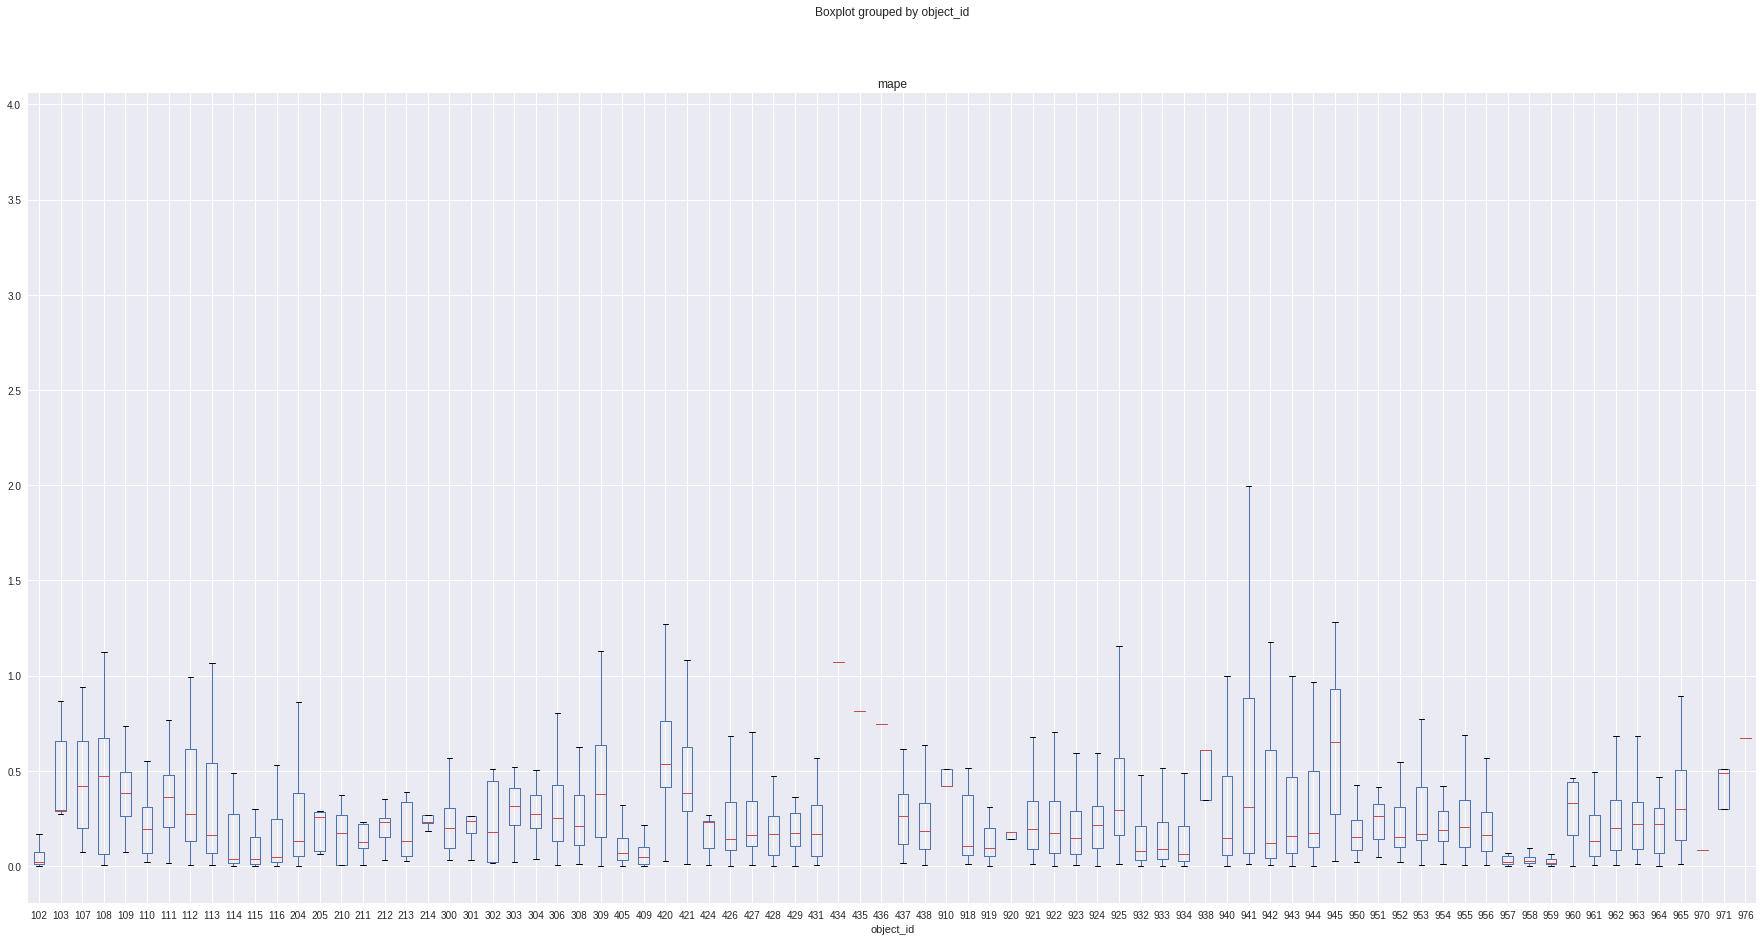

In [0]:
f, ax = plt.subplots(1, 1, figsize=(30,15))
train_df.merge(mape_df, left_on='process_id', right_index=True).boxplot(by='object_id', column='mape', ax=ax)
plt.show()

In [0]:
train_df.groupby('pipeline')['object_id'].unique()

pipeline
L1     [111, 115, 113, 114, 110, 116, 112, 108, 102, ...
L10    [959, 954, 953, 950, 955, 957, 956, 951, 958, ...
L11                  [962, 964, 961, 966, 963, 965, 960]
L12                                 [971, 976, 970, 977]
L2     [204, 214, 217, 216, 212, 215, 205, 211, 210, ...
L3         [301, 306, 304, 309, 302, 308, 300, 305, 303]
L4     [405, 431, 420, 421, 428, 437, 426, 427, 409, ...
L6              [914, 911, 918, 913, 919, 912, 917, 910]
L7                   [921, 926, 924, 922, 923, 925, 920]
L8                             [932, 933, 930, 934, 938]
L9                   [945, 944, 942, 943, 946, 940, 941]
Name: object_id, dtype: object

0.4246037829114286


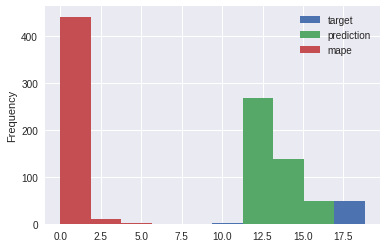

In [0]:
# Combination = 15, MAPE = 0.2541404160732332+-0.008084878815854842
# defaultdict(<class 'list'>, {(15, 15): [0.25951346090584504, 0.258905309505478, 0.26311431908516414, 0.24704318750373339, 0.24212580336594555]})

real_processes = set(train_df[train_df['object_id'].isin([945, 944, 942, 943, 946, 940, 941])]['process_id']).intersection(train_features.index)
real_predictions = mape_df.loc[real_processes]
print(custom_mape(np.exp(real_predictions['prediction']), np.exp(real_predictions['target'])))
real_predictions.plot(kind='hist')

0.24252786199161322
161


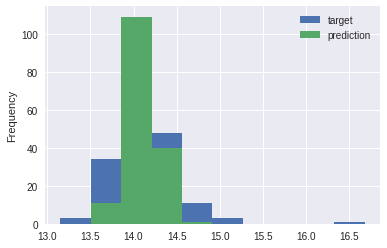

In [0]:
real_processes = set(train_df[train_df['object_id'].isin(range(910, 915))]['process_id']).intersection(train_features.index)
real_predictions = mape_df.loc[real_processes]
print(custom_mape(np.exp(real_predictions['prediction']), np.exp(real_predictions['target'])))
print(len(real_processes))
real_predictions.plot(kind='hist')

In [0]:
custom_mape(np.exp(real_predictions['prediction'] - 0.125), np.exp(real_predictions['target']))

0.35997359931718975

In [0]:
len(real_processes)

425

In [0]:
len(set(train_df[train_df['object_id'].isin(range(910, 915))]['process_id']))

164

In [0]:
X_tsne_df = pd.DataFrame(X_tsne, columns=['tsne_{}'.format(i) for i in range(3)], index=X.index)
X_train = pd.concat([X_train, X_tsne_df.loc[X_train.index]], axis=1)
X_test = pd.concat([X_test, X_tsne_df.loc[X_test.index]], axis=1)

In [0]:
def fit_model(X_train, y_train, X_test):
  train_idx = np.random.choice(X_train.index, replace=False, size=int(0.95 * len(X_train)))
  val_idx = list(set(X_train.index) - set(train_idx))

  X_val = X_train.loc[val_idx, :]
  y_val = y_train.loc[val_idx]
  X_train = X_train.loc[train_idx, :]
  y_train = y_train.loc[train_idx]

  cat = CatBoostRegressor(iterations=100000, od_type='Iter', od_wait=100, 
                          learning_rate=0.33, loss_function='MAPE', eval_metric='MAPE', task_type='GPU')
  cat.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=50)
    

  predictions = cat.predict(X_test)

  explainer = shap.TreeExplainer(cat)
  shap_values = explainer.shap_values(pd.concat([X_train, X_val, X_test]))

  plt.figure()
  shap.summary_plot(shap_values, pd.concat([X_train, X_val, X_test]), max_display=30, 
                    auto_size_plot=True, show=False, color_bar=False)
  plt.show()
  
  return predictions

In [0]:
combinations_per_recipe = {
    3: [1, 3], 
    9: [8],
    15: [15]#, 3, 7, 1]
}

mode = 'turbidity'

prediction_df = None
import warnings; warnings.filterwarnings('ignore')
for recipe in [15]:
  for process_combination in combinations_per_recipe[recipe]:
    train_features = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_features_{}_{}.csv'.format(recipe, process_combination), index_col=0)
    test_features = pd.read_csv('/content/drive/My Drive/Rinse Over Run/test_features_{}_{}.csv'.format(recipe, process_combination), index_col=0)
    labels = pd.read_csv('/content/drive/My Drive/Rinse Over Run/final_phase_labels_{}_{}.csv'.format(recipe, process_combination), index_col=0)
    
    X_train = train_features.drop('target', axis=1)
    y_train = np.log(np.maximum(labels.loc[X_train.index]['return_turbidity_mean'], 0) + 1) + 1
    
    X_test = test_features
    
    to_drop = remove_features(X_train, y_train)
    print(len(to_drop), to_drop)

    X_train = X_train.drop(to_drop, axis=1)
    X_test = X_test.drop(to_drop, axis=1)
    
    N_SPLITS = 5
    train_predictions = np.zeros((len(X_train),))
    test_predictions = np.zeros((len(X_test), N_SPLITS))
    kf = KFold(n_splits=N_SPLITS, shuffle=True)
    for fold_ix, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
      X_cv_train = X_train.iloc[train_idx, :]
      X_cv_test = X_train.iloc[test_idx, :]
      y_cv_train = y_train.iloc[train_idx]
      y_cv_test = y_train.iloc[test_idx]
            
      train_idx = np.random.choice(X_cv_train.index, replace=False, size=int(0.9 * len(X_cv_train)))
      val_idx = list(set(X_cv_train.index) - set(train_idx))

      X_cv_val = X_cv_train.loc[val_idx, :]
      y_cv_val = y_cv_train.loc[val_idx]
      X_cv_train = X_cv_train.loc[train_idx, :]
      y_cv_train = y_cv_train.loc[train_idx]

      cat = CatBoostRegressor(iterations=100000, od_type='Iter', od_wait=100, 
                              loss_function='MAPE', eval_metric='MAPE', task_type='GPU')
      cat.fit(X_cv_train, y_cv_train, eval_set=(X_cv_val, y_cv_val), verbose=50)
      explainer = shap.TreeExplainer(cat)
      shap_values = explainer.shap_values(pd.concat([X_cv_train, X_cv_val, X_cv_test]))

      plt.figure()
      shap.summary_plot(shap_values, pd.concat([X_cv_train, X_cv_val, X_cv_test]), max_display=30, 
                        auto_size_plot=True, show=False, color_bar=False)
      plt.show()

#       print('Fold #{} MAPE={}'.format(fold_ix + 1, custom_mape(np.exp(y_cv_test), np.exp(lgbm.predict(X_cv_test.values)))))
      plt.figure()
      plt.scatter(x=cat.predict(X_cv_test.values), y=y_cv_test)
      plt.title('y vs y_hat')
      plt.show()

      train_predictions[test_idx] = np.maximum(0, cat.predict(X_cv_test.values))
      test_predictions[:, fold_ix] = np.maximum(0, cat.predict(X_test.values))


    name = 'cat'
    train_predictions_df = pd.DataFrame(train_predictions, index=X_train.index, columns=['{}_return_{}_mean_pred'.format(name, mode)])
    test_predictions_df = pd.DataFrame(np.mean(test_predictions, axis=1), index=X_test.index, columns=['{}_return_{}_mean_pred'.format(name, mode)])
    train_predictions_df.to_csv('/content/drive/My Drive/Rinse Over Run/train_predictions_stack_{}_cat_{}_{}.csv'.format(mode, recipe, process_combination))
    test_predictions_df.to_csv('/content/drive/My Drive/Rinse Over Run/test_predictions_stack_{}_cat_{}_{}.csv'.format(mode, recipe, process_combination))    

310 correlated feature pairs left...
278 correlated feature pairs left...
248 correlated feature pairs left...
220 correlated feature pairs left...
194 correlated feature pairs left...
170 correlated feature pairs left...
148 correlated feature pairs left...
128 correlated feature pairs left...
128 correlated feature pairs left...
110 correlated feature pairs left...
110 correlated feature pairs left...
94 correlated feature pairs left...
92 correlated feature pairs left...
78 correlated feature pairs left...
76 correlated feature pairs left...
64 correlated feature pairs left...
54 correlated feature pairs left...
52 correlated feature pairs left...
52 correlated feature pairs left...
50 correlated feature pairs left...
42 correlated feature pairs left...
38 correlated feature pairs left...
36 correlated feature pairs left...
36 correlated feature pairs left...
32 correlated feature pairs left...
32 correlated feature pairs left...
30 correlated feature pairs left...
24 correlated fea

CatboostError: ignored

In [0]:
test_predictions_df

,cat_return_turbidity_pred
24580,5.914807
24584,5.644364
24626,5.304726
24642,4.362046
24646,5.183646
24656,4.183680
24679,4.093109
24694,4.540121
24704,5.420877
24713,5.381925


0:	learn: 0.9847977	test: 0.9844158	best: 0.9844158 (0)	total: 82.7ms	remaining: 2h 17m 49s
50:	learn: 0.2510341	test: 0.2353900	best: 0.2353900 (50)	total: 4.1s	remaining: 2h 14m 3s
100:	learn: 0.0749283	test: 0.0828953	best: 0.0828953 (100)	total: 8.83s	remaining: 2h 25m 36s
150:	learn: 0.0603440	test: 0.0779396	best: 0.0779396 (150)	total: 13.4s	remaining: 2h 27m 59s
200:	learn: 0.0541097	test: 0.0757793	best: 0.0756101 (193)	total: 17.9s	remaining: 2h 28m 30s
250:	learn: 0.0497491	test: 0.0757844	best: 0.0747406 (226)	total: 22.4s	remaining: 2h 28m 41s
300:	learn: 0.0462828	test: 0.0757284	best: 0.0747221 (267)	total: 27s	remaining: 2h 28m 51s
350:	learn: 0.0426968	test: 0.0749458	best: 0.0745568 (336)	total: 31.6s	remaining: 2h 29m 33s
400:	learn: 0.0399258	test: 0.0747417	best: 0.0743500 (370)	total: 36.3s	remaining: 2h 30m 7s
450:	learn: 0.0375007	test: 0.0750981	best: 0.0743500 (370)	total: 40.9s	remaining: 2h 30m 32s
bestTest = 0.07435003703
bestIteration = 370
Shrink model to

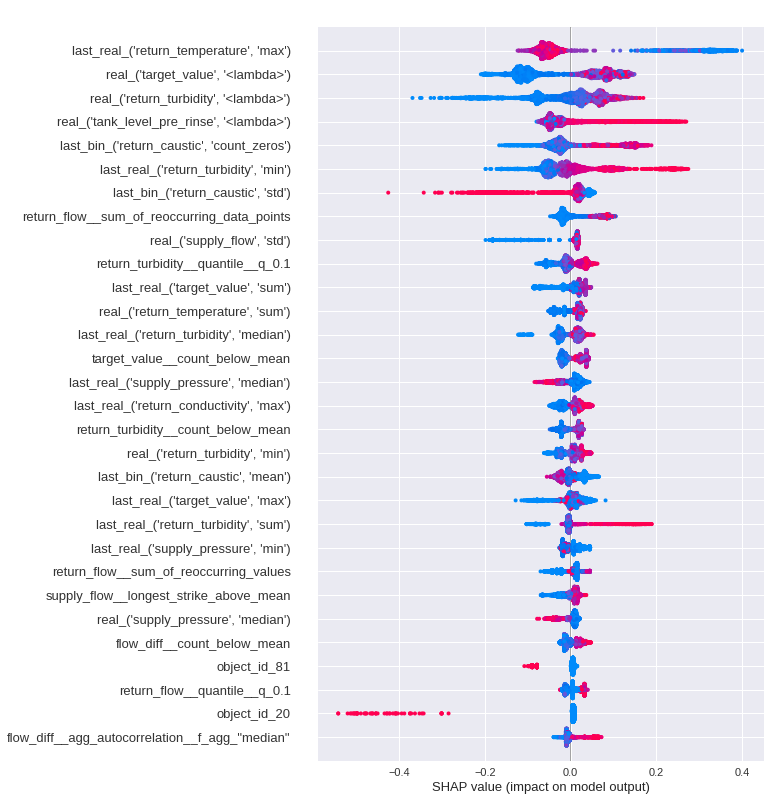

TEST MAPE = 0.0009895227749474591


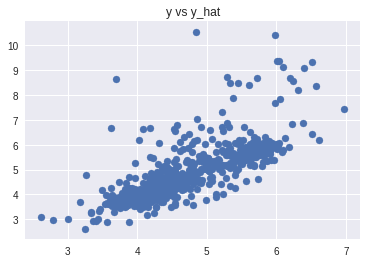

0:	learn: 0.9847355	test: 0.9848558	best: 0.9848558 (0)	total: 117ms	remaining: 3h 15m 25s
50:	learn: 0.2466891	test: 0.2488203	best: 0.2488203 (50)	total: 4.22s	remaining: 2h 18m
100:	learn: 0.0751994	test: 0.0879523	best: 0.0879523 (100)	total: 8.95s	remaining: 2h 27m 28s
150:	learn: 0.0606749	test: 0.0796393	best: 0.0789784 (146)	total: 13.4s	remaining: 2h 28m 13s
200:	learn: 0.0548824	test: 0.0776885	best: 0.0776031 (199)	total: 17.9s	remaining: 2h 28m 3s
250:	learn: 0.0498725	test: 0.0755759	best: 0.0754411 (249)	total: 22.5s	remaining: 2h 28m 43s
300:	learn: 0.0458789	test: 0.0753446	best: 0.0742884 (271)	total: 27s	remaining: 2h 28m 58s
350:	learn: 0.0423155	test: 0.0740582	best: 0.0739787 (315)	total: 31.6s	remaining: 2h 29m 24s
400:	learn: 0.0396232	test: 0.0752234	best: 0.0739787 (315)	total: 36.2s	remaining: 2h 29m 47s
bestTest = 0.07397872289
bestIteration = 315
Shrink model to first 316 iterations.


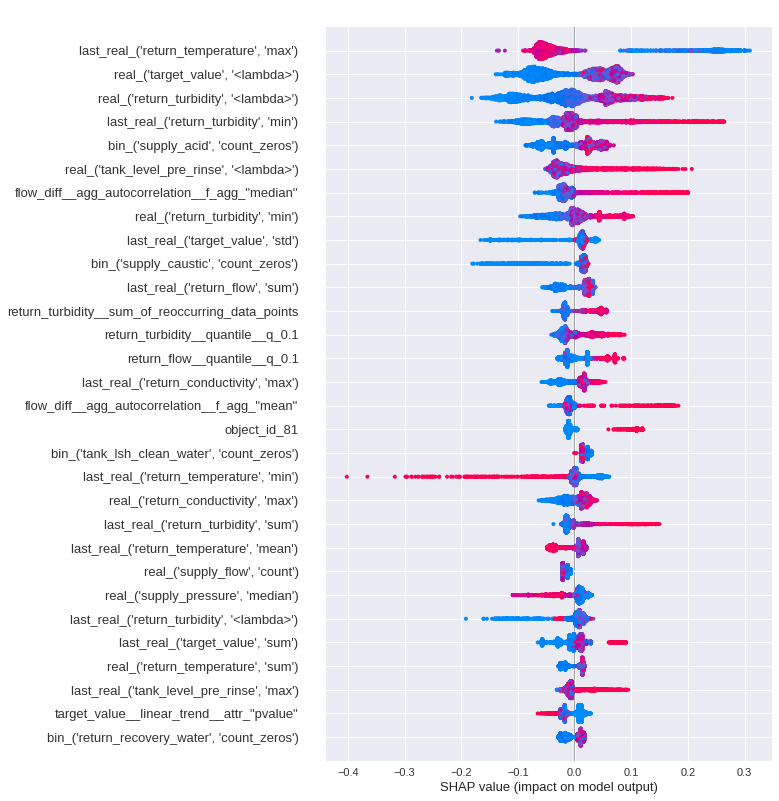

TEST MAPE = 0.0007039750402874286


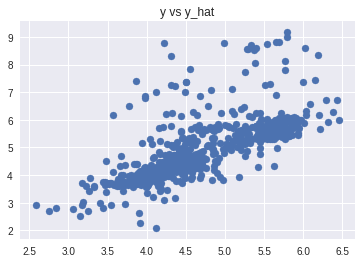

0:	learn: 0.9847519	test: 0.9847825	best: 0.9847825 (0)	total: 110ms	remaining: 3h 4m 1s
50:	learn: 0.2454614	test: 0.2505810	best: 0.2505810 (50)	total: 4.22s	remaining: 2h 17m 54s
100:	learn: 0.0751687	test: 0.0853538	best: 0.0853538 (100)	total: 8.91s	remaining: 2h 26m 53s
150:	learn: 0.0601078	test: 0.0739690	best: 0.0738926 (146)	total: 13.5s	remaining: 2h 28m 35s
200:	learn: 0.0535247	test: 0.0720654	best: 0.0717249 (198)	total: 18s	remaining: 2h 28m 45s
250:	learn: 0.0490813	test: 0.0715923	best: 0.0715377 (249)	total: 22.5s	remaining: 2h 29m 3s
300:	learn: 0.0450135	test: 0.0722803	best: 0.0713781 (273)	total: 27.1s	remaining: 2h 29m 44s
350:	learn: 0.0414446	test: 0.0720808	best: 0.0713781 (273)	total: 31.8s	remaining: 2h 30m 40s
bestTest = 0.07137806575
bestIteration = 273
Shrink model to first 274 iterations.


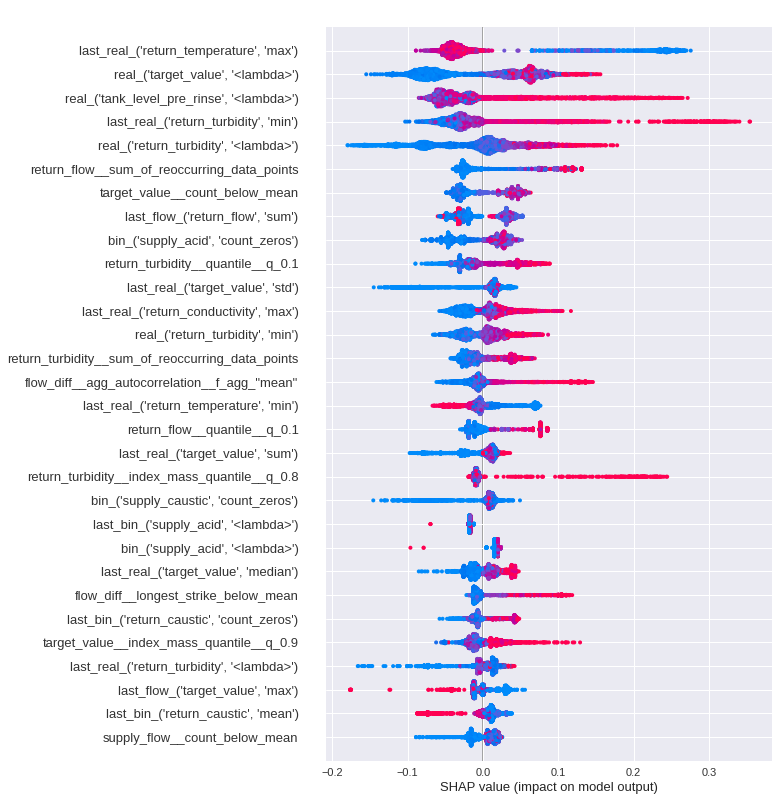

TEST MAPE = 0.0007834721291678209


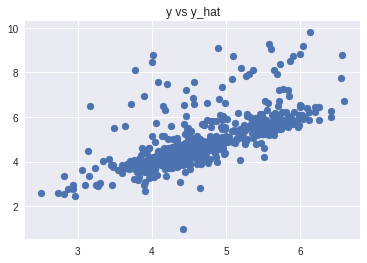

0:	learn: 0.9847092	test: 0.9848179	best: 0.9848179 (0)	total: 120ms	remaining: 3h 20m 4s
50:	learn: 0.2429857	test: 0.2618952	best: 0.2618952 (50)	total: 4.35s	remaining: 2h 21m 57s
100:	learn: 0.0749632	test: 0.1048881	best: 0.1048881 (100)	total: 9.08s	remaining: 2h 29m 43s
150:	learn: 0.0602786	test: 0.0914616	best: 0.0914616 (150)	total: 13.6s	remaining: 2h 30m
200:	learn: 0.0532952	test: 0.0900448	best: 0.0895991 (188)	total: 18.1s	remaining: 2h 30m 9s
250:	learn: 0.0483695	test: 0.0893744	best: 0.0887459 (226)	total: 22.7s	remaining: 2h 30m 29s
300:	learn: 0.0448115	test: 0.0895524	best: 0.0887459 (226)	total: 27.2s	remaining: 2h 30m 14s
350:	learn: 0.0413666	test: 0.0881320	best: 0.0877604 (344)	total: 31.9s	remaining: 2h 30m 47s
400:	learn: 0.0380494	test: 0.0873688	best: 0.0872173 (392)	total: 36.6s	remaining: 2h 31m 40s


KeyboardInterrupt: ignored

In [0]:
recipe = 15
process_combination = 15
train_features = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_features_{}_{}.csv'.format(recipe, process_combination), index_col=0)
test_features = pd.read_csv('/content/drive/My Drive/Rinse Over Run/test_features_{}_{}.csv'.format(recipe, process_combination), index_col=0)
labels = pd.read_csv('/content/drive/My Drive/Rinse Over Run/final_phase_labels_{}_{}.csv'.format(recipe, process_combination), index_col=0)

X_train = train_features.drop('target', axis=1)
y_train = np.log(np.maximum(0, labels.loc[X_train.index]['return_turbidity_sum']) + 1) + 1

kf = KFold(n_splits=5, random_state=2019)
mapes = []
shaps = []
for train_idx, test_idx in kf.split(X_train, y_train):
  X_cv_train = X_train.iloc[train_idx, :]
  X_cv_test = X_train.iloc[test_idx, :]

  y_cv_train = y_train.iloc[train_idx]
  y_cv_test = y_train.iloc[test_idx]

  total_predictions = np.exp(fit_model(X_cv_train, y_cv_train, X_cv_test))
  mape = custom_mape(total_predictions, np.exp(y_cv_test))
  print('TEST MAPE = {}'.format(mape))
  mapes.append(mape)
  all_mapes[(recipe, process_combination)].append(mape)

  plt.figure()
  plt.scatter(x=np.log(total_predictions), y=y_cv_test)
  plt.title('y vs y_hat')
  plt.show()

print('Combination = {}, MAPE = {}+-{}'.format(process_combination, np.mean(mapes), np.std(mapes)))

In [0]:
large_targets = y_train[y_train > 16].index
train_df[train_df['process_id'].isin(large_targets)].groupby('object_id')['process_id'].nunique()

object_id
111     1
923     1
932     9
933    12
934    13
940     9
941    16
942     8
943    12
944     7
945    17
965     1
Name: process_id, dtype: int64

In [0]:
len(large_targets)

106

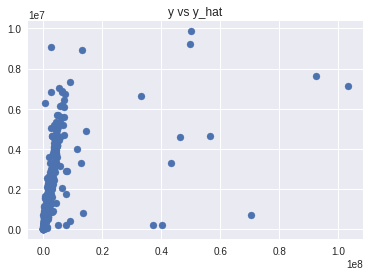

In [0]:

plt.figure()
plt.scatter(y=total_predictions, x=np.exp(y_cv_test))
plt.title('y vs y_hat')
plt.show()

In [0]:
def mape_1_row(x):
  return abs(np.exp(x['prediction']) - np.exp(x['target'])) / max(290000, np.exp(x['target']))

mape_df['mape'] = mape_df.apply(mape_1_row, axis=1)
mape_df

,target,prediction,mape
24581,13.532277,13.461864,0.067991
24586,14.083414,13.923641,0.147663
24588,15.231898,15.166487,0.063317
24589,13.351943,13.302765,0.047988
24593,15.245114,15.251239,0.006144
24595,12.749774,12.609214,0.131129
24599,13.528019,13.895399,0.443947
24601,12.929929,13.351330,0.524095
24602,13.256726,13.204242,0.051131
24603,13.347870,13.766540,0.519938


Learning rate set to 0.012343
0:	learn: 0.6823250	test: 0.6820762	best: 0.6820762 (0)	total: 171ms	remaining: 4h 44m 52s
50:	learn: 0.4139559	test: 0.4036038	best: 0.4036038 (50)	total: 5.65s	remaining: 3h 4m 34s
100:	learn: 0.3379530	test: 0.3305384	best: 0.3305384 (100)	total: 11.1s	remaining: 3h 3m 47s
150:	learn: 0.3100059	test: 0.3078992	best: 0.3078992 (150)	total: 16.6s	remaining: 3h 2m 56s
200:	learn: 0.2954569	test: 0.2996381	best: 0.2996381 (200)	total: 22s	remaining: 3h 1m 58s
250:	learn: 0.2828914	test: 0.2935224	best: 0.2935224 (250)	total: 27.5s	remaining: 3h 1m 58s
300:	learn: 0.2744681	test: 0.2900206	best: 0.2899921 (298)	total: 32.8s	remaining: 3h 1m 15s
350:	learn: 0.2650892	test: 0.2874336	best: 0.2874336 (350)	total: 38.4s	remaining: 3h 1m 29s
400:	learn: 0.2568410	test: 0.2852806	best: 0.2852747 (399)	total: 43.8s	remaining: 3h 1m 25s
450:	learn: 0.2489502	test: 0.2829160	best: 0.2829160 (450)	total: 49.3s	remaining: 3h 1m 20s
500:	learn: 0.2415693	test: 0.2803464

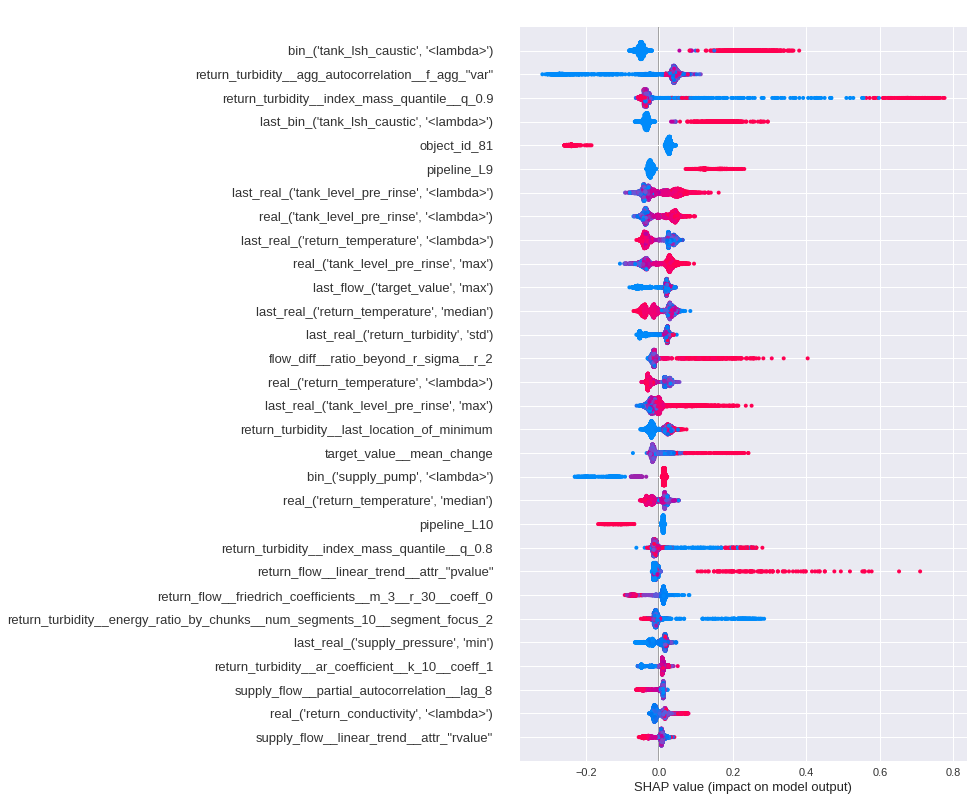

In [0]:
y_mape = (mape_df['mape'] > 0.5).astype(int)
X_train = train_features.loc[y_mape.index].drop('target', axis=1)

train_idx = np.random.choice(X_train.index, replace=False, size=int(0.9 * len(X_train)))
val_idx = list(set(X_train.index) - set(train_idx))

X_val = X_train.loc[val_idx, :]
y_val = y_mape.loc[val_idx]
X_train = X_train.loc[train_idx, :]
y_train = y_mape.loc[train_idx]

cat = CatBoostClassifier(iterations=100000, od_type='Iter', od_wait=100, task_type='GPU')
cat.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=50)
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(pd.concat([X_train, X_val]))

plt.figure()
shap.summary_plot(shap_values, pd.concat([X_train, X_val]), max_display=30, 
                  auto_size_plot=True, show=False, color_bar=False)
plt.show()

In [0]:
high_error_machines = train_df[train_df['process_id'].isin(mape_df[mape_df['mape'] > 0.5].index)].groupby('object_id')['process_id'].nunique()
nr_machines = train_df[train_df['object_id'].isin(high_error_machines.index)].groupby('object_id')['process_id'].nunique()

In [0]:
high_error_machines / nr_machines

object_id
102    0.020000
103    0.428571
107    0.333333
108    0.350000
109    0.095238
110    0.095238
111    0.166667
112    0.248000
113    0.149533
114    0.105263
115    0.092593
116    0.125000
204    0.103030
300    0.030769
301    0.015625
304    0.090909
306    0.153061
308    0.102273
309    0.175000
405    0.008571
420    0.323529
421    0.333333
426    0.043478
428    0.031250
429    0.032258
431    0.041667
434    1.000000
435    1.000000
436    1.000000
437    0.105263
438    0.125000
921    0.070000
922    0.081633
923    0.081633
924    0.095745
925    0.253968
932    0.129730
933    0.153846
934    0.162011
938    0.500000
940    0.244186
941    0.348837
942    0.232558
943    0.202381
944    0.247059
945    0.666667
950    0.033333
951    0.076923
952    0.111111
953    0.117647
955    0.190476
960    0.100000
961    0.020833
962    0.090909
963    0.152174
964    0.085106
965    0.125000
Name: process_id, dtype: float64

In [0]:
set(train_df[train_df['pipeline'] == 'L8']['object_id'])

{930, 932, 933, 934, 938}

In [0]:
sum([x >= 920 for x in set(train_df['object_id'])])

40

In [0]:
high_error_machines[high_error_machines > 5].index

Int64Index([107, 108, 112, 113, 114, 116, 204, 306, 308, 309, 420, 421, 921,
            922, 923, 924, 925, 932, 933, 934, 940, 941, 942, 943, 944, 945,
            955, 963],
           dtype='int64', name='object_id')

In [0]:
set(train_df['pipeline'])

{'L1', 'L10', 'L11', 'L12', 'L2', 'L3', 'L4', 'L6', 'L7', 'L8', 'L9'}

In [0]:
def fit_model(X_train, y_train, X_test, processes=None):
  train_idx = np.random.choice(X_train.index, replace=False, size=int(0.95 * len(X_train)))
  val_idx = list(set(X_train.index) - set(train_idx))

  X_val = X_train.loc[val_idx, :]
  y_val = y_train.loc[val_idx]
  X_train = X_train.loc[train_idx, :]
  y_train = y_train.loc[train_idx]
 
  cat = CatBoostRegressor(iterations=100000, od_type='Iter', od_wait=100, 
                          loss_function='MAPE', eval_metric='MAPE', task_type='GPU')
  cat.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=50)
    

  predictions = cat.predict(X_test)

  explainer = shap.TreeExplainer(cat)
  shap_values = explainer.shap_values(pd.concat([X_train, X_val, X_test]))

  plt.figure()
  shap.summary_plot(shap_values, pd.concat([X_train, X_val, X_test]), max_display=30, 
                    auto_size_plot=True, show=False, color_bar=False)
  plt.show()
  
  return predictions

def custom_mape(approxes, targets):
    return np.mean(np.abs(np.subtract(approxes, targets)) / np.maximum(np.abs(targets), 0))

1040 correlated feature pairs left...
996 correlated feature pairs left...
954 correlated feature pairs left...
914 correlated feature pairs left...
876 correlated feature pairs left...
838 correlated feature pairs left...
802 correlated feature pairs left...
766 correlated feature pairs left...
732 correlated feature pairs left...
700 correlated feature pairs left...
696 correlated feature pairs left...
694 correlated feature pairs left...
664 correlated feature pairs left...
630 correlated feature pairs left...
628 correlated feature pairs left...
596 correlated feature pairs left...
566 correlated feature pairs left...
538 correlated feature pairs left...
512 correlated feature pairs left...
488 correlated feature pairs left...
466 correlated feature pairs left...
446 correlated feature pairs left...
444 correlated feature pairs left...
426 correlated feature pairs left...
398 correlated feature pairs left...
396 correlated feature pairs left...
380 correlated feature pairs left...


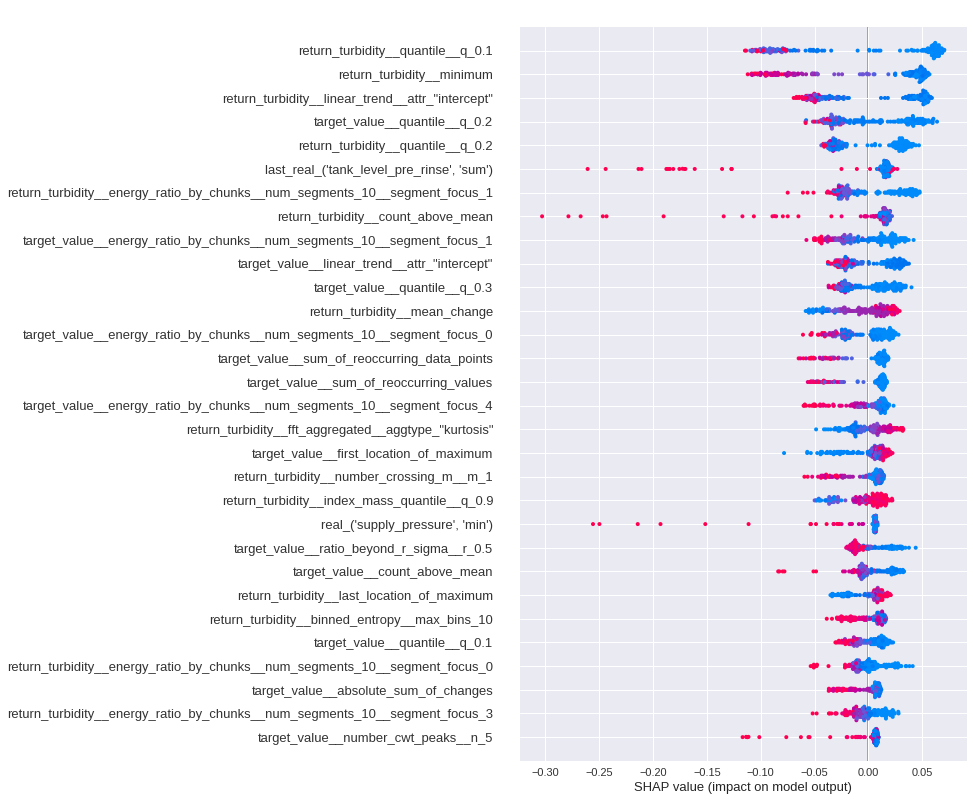

TEST MAPE = 0.9413769827228836


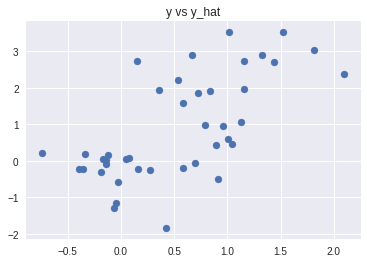

0:	learn: 0.9973669	test: 0.9964413	best: 0.9964413 (0)	total: 59.2ms	remaining: 1h 38m 43s
50:	learn: 0.8692352	test: 0.8395539	best: 0.8395539 (50)	total: 2.68s	remaining: 1h 27m 30s
100:	learn: 0.7439079	test: 0.6867869	best: 0.6867869 (100)	total: 5.14s	remaining: 1h 24m 41s
150:	learn: 0.6553233	test: 0.5656971	best: 0.5656971 (150)	total: 7.69s	remaining: 1h 24m 47s
200:	learn: 0.5674768	test: 0.4577317	best: 0.4577317 (200)	total: 10.3s	remaining: 1h 25m
250:	learn: 0.4793983	test: 0.3780714	best: 0.3780714 (250)	total: 12.9s	remaining: 1h 25m 24s
300:	learn: 0.4003601	test: 0.3286123	best: 0.3286123 (300)	total: 15.5s	remaining: 1h 25m 43s
350:	learn: 0.3419162	test: 0.3158056	best: 0.3154013 (346)	total: 18.2s	remaining: 1h 26m 17s
400:	learn: 0.3069677	test: 0.3036395	best: 0.3034926 (399)	total: 21s	remaining: 1h 26m 47s
450:	learn: 0.2802998	test: 0.2929157	best: 0.2921826 (448)	total: 23.7s	remaining: 1h 27m 21s
500:	learn: 0.2589351	test: 0.2865055	best: 0.2855724 (488)	t

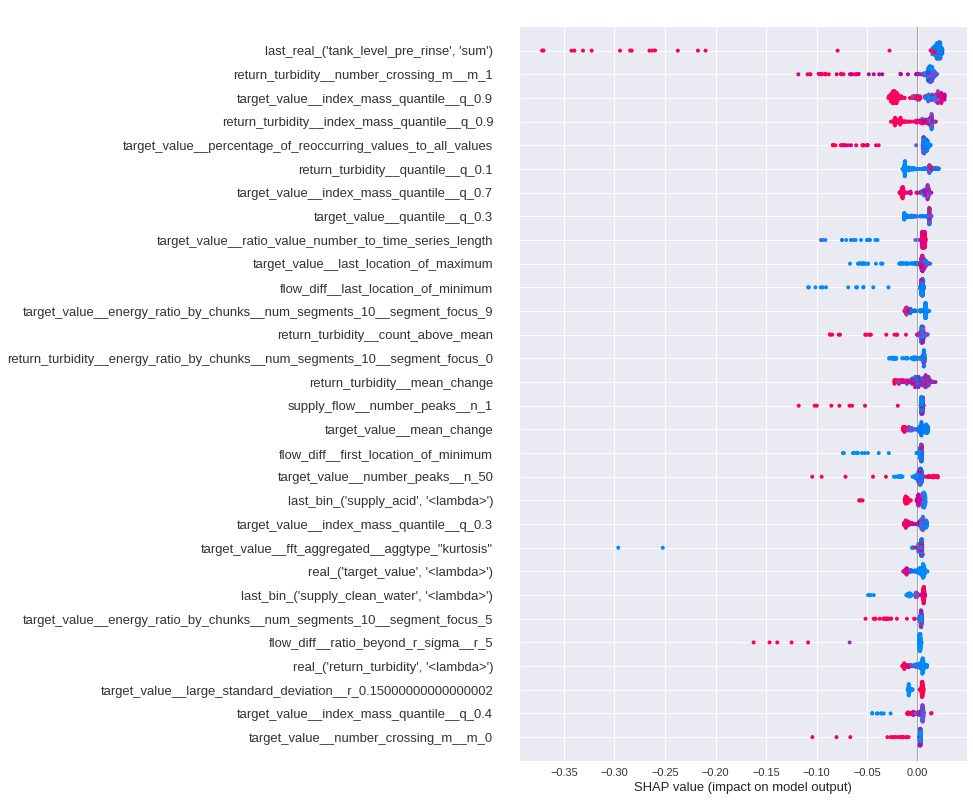

TEST MAPE = 0.9676067519002114


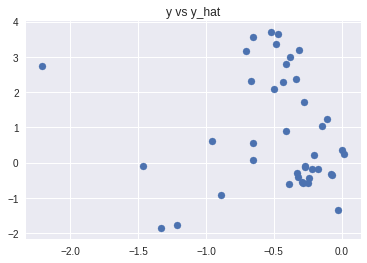

0:	learn: 0.9972047	test: 0.9973182	best: 0.9973182 (0)	total: 54.5ms	remaining: 1h 30m 52s
50:	learn: 0.8555360	test: 0.8664540	best: 0.8664540 (50)	total: 2.7s	remaining: 1h 28m 11s
100:	learn: 0.7270609	test: 0.7484020	best: 0.7484020 (100)	total: 5.23s	remaining: 1h 26m 14s
150:	learn: 0.6357969	test: 0.6712936	best: 0.6712936 (150)	total: 7.88s	remaining: 1h 26m 49s
200:	learn: 0.5457659	test: 0.6208889	best: 0.6208889 (200)	total: 10.5s	remaining: 1h 26m 40s
250:	learn: 0.4621532	test: 0.5729629	best: 0.5729629 (250)	total: 13.2s	remaining: 1h 27m 8s
300:	learn: 0.3869261	test: 0.5256527	best: 0.5256527 (300)	total: 15.9s	remaining: 1h 27m 43s
350:	learn: 0.3271668	test: 0.4813347	best: 0.4813347 (350)	total: 18.6s	remaining: 1h 28m 1s
400:	learn: 0.2885697	test: 0.4602535	best: 0.4602535 (400)	total: 21.3s	remaining: 1h 28m 12s
450:	learn: 0.2667654	test: 0.4475723	best: 0.4474916 (448)	total: 24s	remaining: 1h 28m 23s
500:	learn: 0.2481206	test: 0.4407847	best: 0.4388363 (494)	

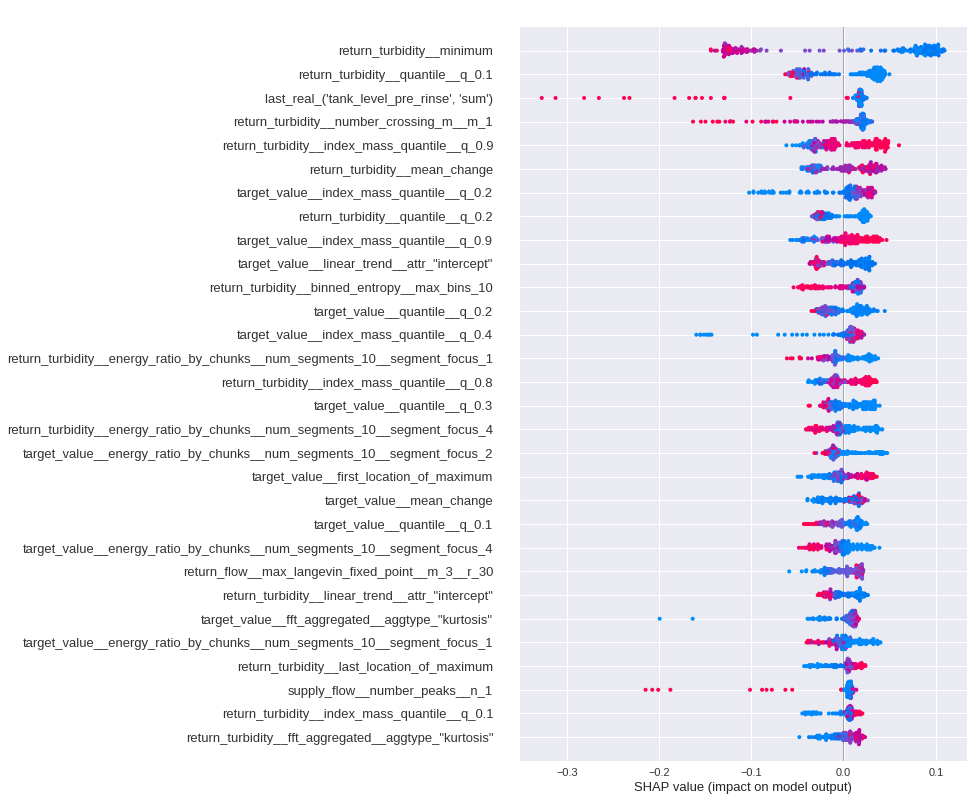

TEST MAPE = 0.9500705393557787


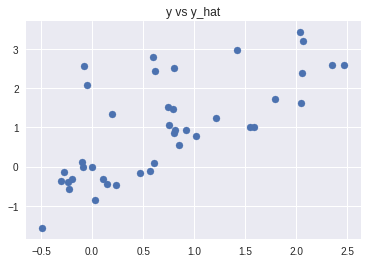

0:	learn: 0.9974399	test: 0.9977606	best: 0.9977606 (0)	total: 75.9ms	remaining: 2h 6m 34s
50:	learn: 0.8625209	test: 0.8925788	best: 0.8925788 (50)	total: 2.75s	remaining: 1h 29m 49s
100:	learn: 0.7304100	test: 0.7845232	best: 0.7845232 (100)	total: 5.27s	remaining: 1h 26m 55s
150:	learn: 0.6350923	test: 0.6951136	best: 0.6951136 (150)	total: 7.94s	remaining: 1h 27m 30s
200:	learn: 0.5402221	test: 0.6070859	best: 0.6070859 (200)	total: 10.6s	remaining: 1h 27m 52s
250:	learn: 0.4563558	test: 0.5227878	best: 0.5227878 (250)	total: 13.4s	remaining: 1h 28m 46s
300:	learn: 0.3794361	test: 0.4422849	best: 0.4422849 (300)	total: 16.1s	remaining: 1h 29m
350:	learn: 0.3222984	test: 0.3798988	best: 0.3798988 (350)	total: 18.9s	remaining: 1h 29m 21s
400:	learn: 0.2845693	test: 0.3518845	best: 0.3518845 (400)	total: 21.7s	remaining: 1h 29m 41s
450:	learn: 0.2638353	test: 0.3441452	best: 0.3441452 (450)	total: 24.5s	remaining: 1h 30m
500:	learn: 0.2469635	test: 0.3349621	best: 0.3349621 (500)	tota

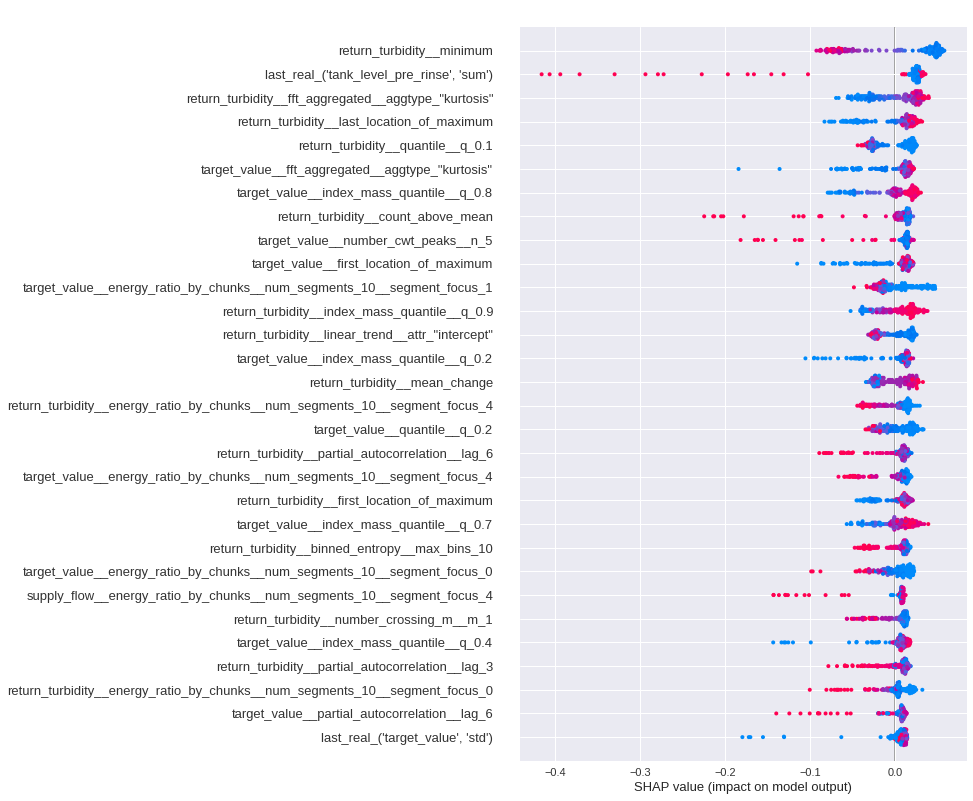

TEST MAPE = 0.9330046204591816


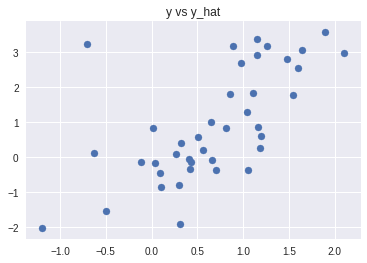

0:	learn: 0.9974125	test: 0.9975003	best: 0.9975003 (0)	total: 82.2ms	remaining: 2h 17m
50:	learn: 0.8709673	test: 0.8751604	best: 0.8751604 (50)	total: 2.88s	remaining: 1h 34m 15s
100:	learn: 0.7459195	test: 0.7535373	best: 0.7535373 (100)	total: 5.3s	remaining: 1h 27m 23s
150:	learn: 0.6450230	test: 0.6447227	best: 0.6447227 (150)	total: 7.99s	remaining: 1h 28m 1s
200:	learn: 0.5500835	test: 0.5348648	best: 0.5348648 (200)	total: 10.6s	remaining: 1h 27m 55s
250:	learn: 0.4592002	test: 0.4290826	best: 0.4290826 (250)	total: 13.3s	remaining: 1h 28m 3s
300:	learn: 0.3826214	test: 0.3345689	best: 0.3345689 (300)	total: 16s	remaining: 1h 28m 34s
350:	learn: 0.3284932	test: 0.2750326	best: 0.2750326 (350)	total: 18.8s	remaining: 1h 29m
400:	learn: 0.2930505	test: 0.2472709	best: 0.2472709 (400)	total: 21.6s	remaining: 1h 29m 27s
450:	learn: 0.2663687	test: 0.2334788	best: 0.2334788 (450)	total: 24.4s	remaining: 1h 29m 53s
500:	learn: 0.2439630	test: 0.2235853	best: 0.2235853 (500)	total: 2

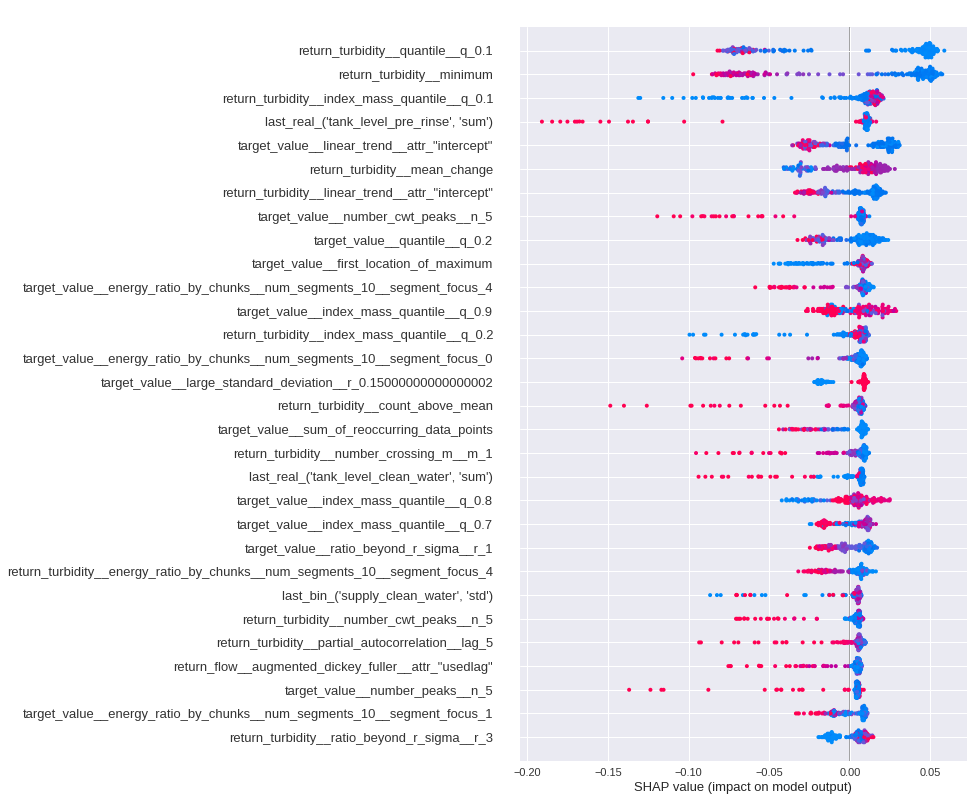

TEST MAPE = 0.951196155942907


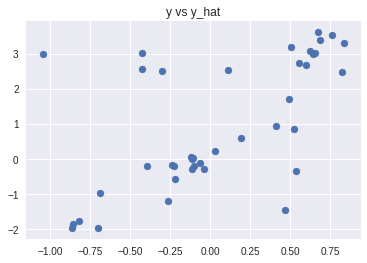

L9 Combination = 15, MAPE = 0.9486510100761926+-0.011537191694180228
defaultdict(<class 'list'>, {(15, 15): [0.9413769827228836, 0.9676067519002114, 0.9500705393557787, 0.9330046204591816, 0.951196155942907]})


In [0]:
import warnings; warnings.filterwarnings('ignore')

from sklearn.manifold import TSNE

combinations_per_recipe = {
    3: [1, 2, 3], 
    9: [8],
    15: [15]
}

weights = {
    (3, 1): 0.0219,
    (3, 2): 0.0064,
    (3, 3): 0.1695,
    (9, 8): 0.0411,
    (15, 1): 0.0765,
    (15, 2): 0.0013,
    (15, 3): 0.2289,
    (15, 6): 0.0007,
    (15, 7): 0.2258,
    (15, 14): 0.0017,
    (15, 15): 0.2262,
}

all_mapes = defaultdict(list)
for recipe in [15]:
  for process_combination in combinations_per_recipe[recipe]:
      train_features = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_features_{}_{}.csv'.format(recipe, process_combination), index_col=0)
      test_features = pd.read_csv('/content/drive/My Drive/Rinse Over Run/test_features_{}_{}.csv'.format(recipe, process_combination), index_col=0)
      labels = pd.read_csv('/content/drive/My Drive/Rinse Over Run/final_phase_labels_{}_{}.csv'.format(recipe, process_combination), index_col=0)
      
      for pipeline in ['L9']:
        
        procs = set(train_df[train_df['pipeline'] == pipeline]['process_id'])
        procs = procs.intersection(train_features.index)
        X_train = train_features.loc[procs].drop('target', axis=1)
        y_train = np.log(train_features.loc[procs]['target'])
        
        y_train = np.log(turbidity_labels['return_turbidity_mean'])#y_train[y_train > 13]
        y_min = np.min(y_train)
        y_train = y_train - y_min + 1
        X_train = X_train.loc[y_train.index]

        X_test = test_features

        to_drop = remove_features(X_train, y_train)
        X_test = X_test.drop(to_drop, axis=1)
        X_train = X_train.drop(to_drop, axis=1)

#         print(X_train.shape, X_test.shape)
#         for file in glob.glob('/content/drive/My Drive/Rinse Over Run/train_predictions_stack_*_{}_{}.csv'.format(recipe, process_combination)):
#             if ('_lgbm_' in file and '_flow' in file) or ('_rf_' in file): continue

#             train_predictions = pd.read_csv(file, index_col=0)
#             X_train = X_train.merge(train_predictions, left_index=True, right_index=True)

#         for file in glob.glob('/content/drive/My Drive/Rinse Over Run/test_predictions_stack_*_{}_{}.csv'.format(recipe, process_combination)):
#           if ('_lgbm_' in file and '_flow' in file) or ('_rf_' in file): continue
#           test_predictions = pd.read_csv(file, index_col=0)
#           X_test = X_test.merge(test_predictions, left_index=True, right_index=True)

        kf = KFold(n_splits=5, random_state=2019, shuffle=True)
        mapes = []
        shaps = []

        for train_idx, test_idx in kf.split(X_train, y_train):
          X_cv_train = X_train.iloc[train_idx, :]
          X_cv_test = X_train.iloc[test_idx, :]

          y_cv_train = y_train.iloc[train_idx]
          y_cv_test = y_train.iloc[test_idx]

          total_predictions = fit_model(X_cv_train, y_cv_train, X_cv_test)
          total_predictions += y_min - 1
          total_predictions = np.exp(total_predictions)
          mape = custom_mape(total_predictions, np.exp(y_cv_test))
          
          print('TEST MAPE = {}'.format(mape))
          mapes.append(mape)
          all_mapes[(recipe, process_combination)].append(mape)

          plt.figure()
          plt.scatter(x=np.log(total_predictions), y=y_cv_test + (y_min - 1))
          plt.title('y vs y_hat')
          plt.show()

        print(pipeline, 'Combination = {}, MAPE = {}+-{}'.format(process_combination, np.mean(mapes), np.std(mapes)))
  print(all_mapes)

In [0]:
turbidity_labels = train_df[(train_df['process_id'].isin(X_train.index)) 
                             & (train_df['phase'] == 'final_rinse') 
                             & (train_df['target_time_period'])].groupby('process_id')[['return_flow', 'return_turbidity']].agg(['sum', 'mean', 'count'])
turbidity_labels.columns = ['return_flow_sum', 'return_flow_mean', 'return_flow_count', 'return_turbidity_sum', 'return_turbidity_mean', 'return_turbidity_count']
# for process in X_train.index:
#   proc_final_data = train_df[(train_df['process_id'] == process) & (train_df['phase'] == 'final_rinse')]
  
#   plt.figure()
#   plt.plot(proc_final_data['return_flow'].values)
#   plt.show()
#   plt.figure()
#   plt.plot(proc_final_data['return_turbidity'].values)
#   plt.show()
  
#   input()

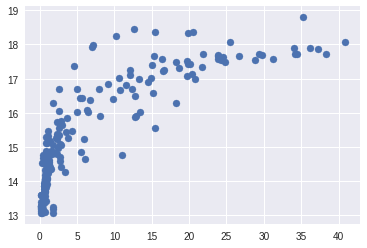

In [0]:
labels = train_df[(train_df['process_id'].isin(train_features.index)) 
                             & (train_df['phase'] == 'final_rinse') 
                             & (train_df['target_time_period'])].groupby('process_id')[['return_flow', 'return_turbidity']].agg(['sum', 'mean', 'count'])
labels.columns = ['return_flow_sum', 'return_flow_mean', 'return_flow_count', 'return_turbidity_sum', 'return_turbidity_mean', 'return_turbidity_count']

plt.scatter(x=turbidity_labels['return_turbidity_mean'], y=np.log(train_features.loc[turbidity_labels.index]['target']))

In [0]:

def mape_1_row(x):
  return abs(np.exp(x['prediction']) - np.exp(x['target'])) / max(290000, np.exp(x['target']))

mape_df['mape'] = mape_df.apply(mape_1_row, axis=1)
mape_df.loc[proc_L10]['mape'].mean()

0.1560414509551531

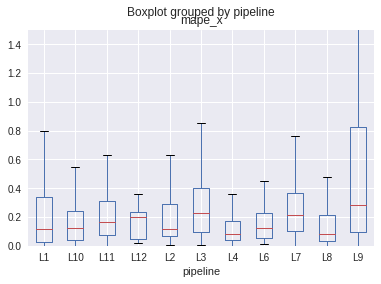

In [0]:
# train_df = train_df.merge(mape_df, left_on='process_id', right_index=True)
axes = train_df.boxplot('mape_x', by='pipeline', return_type='axes')
for ax in axes.values:
    ax.set_ylim(0, 1.5)

plt.show()

In [0]:
labels.loc[X_train.index]['return_turbidity_mean'].describe()


count    3726.000000
mean        0.854045
std         3.006648
min        -0.013161
25%         0.194675
50%         0.257530
75%         0.531730
max        40.862282
Name: return_turbidity_mean, dtype: float64

In [0]:
list(set(real_processes).intersection(set(train_features.index)))

[22530,
 22536,
 22541,
 26639,
 22557,
 26654,
 22587,
 20541,
 22592,
 20550,
 22599,
 22602,
 24654,
 22611,
 20567,
 24682,
 26731,
 22638,
 24686,
 20594,
 24711,
 26761,
 22666,
 22667,
 22668,
 24722,
 20629,
 24726,
 20639,
 20643,
 22695,
 26796,
 24752,
 26809,
 24765,
 24769,
 22724,
 24775,
 24776,
 22736,
 26834,
 26840,
 20702,
 22752,
 24808,
 22761,
 24812,
 24813,
 24817,
 24819,
 22774,
 24824,
 24835,
 20742,
 24839,
 20744,
 22794,
 24852,
 26906,
 20771,
 20775,
 20777,
 24875,
 26925,
 20791,
 24891,
 26940,
 24905,
 20820,
 26965,
 24943,
 27005,
 24968,
 20873,
 20878,
 24978,
 22933,
 27033,
 20890,
 27035,
 20900,
 27044,
 27054,
 25009,
 20929,
 20939,
 20951,
 27098,
 23012,
 25061,
 20966,
 23015,
 20972,
 23027,
 27140,
 21007,
 21010,
 23059,
 27161,
 27167,
 21029,
 21035,
 27186,
 27187,
 23095,
 27193,
 23102,
 25155,
 25170,
 23132,
 27228,
 25185,
 21090,
 27234,
 23142,
 23143,
 23155,
 27259,
 23164,
 23167,
 21120,
 25216,
 25225,
 21139,
 21143,
 23191,
 21145,
 23193,
 27294,
 21157,
 21161,
 23209,
 25257,
 21170,
 27315,
 23226,
 27334,
 25291,
 27343,
 21201,
 27356,
 23262,
 27358,
 21223,
 25327,
 23281,
 23286,
 21239,
 23290,
 25339,
 23299,
 25349,
 25351,
 25352,
 27399,
 25364,
 25365,
 21270,
 27421,
 21280,
 21286,
 23334,
 27432,
 27435,
 25391,
 21296,
 23344,
 25392,
 25395,
 27443,
 21305,
 23356,
 21320,
 23371,
 25429,
 25436,
 27497,
 21355,
 27501,
 23419,
 25475,
 25486,
 23440,
 23443,
 23449,
 21407,
 27552,
 23461,
 21415,
 25514,
 27562,
 23468,
 23469,
 23471,
 27572,
 25528,
 27577,
 25538,
 21461,
 21462,
 21470,
 23520,
 21479,
 25581,
 25587,
 21494,
 25591,
 27640,
 27641,
 27645,
 21510,
 21516,
 27661,
 27664,
 27679,
 23585,
 27691,
 25645,
 21550,
 21554,
 27701,
 27702,
 23607,
 23608,
 27725,
 21583,
 21584,
 25681,
 21589,
 23645,
 21600,
 25700,
 27752,
 27764,
 23674,
 23692,
 21646,
 23694,
 21655,
 27800,
 27810,
 21668,
 21680,
 23734,
 21692,
 25789,
 27836,
 21695,
 27846,
 25802,
 21713,
 25816,
 25818,
 25822,
 23775,
 25825,
 21745,
 21749,
 25845,
 25850,
 25869,
 23824,
 25876,
 23829,
 27929,
 25882,
 27935,
 25893,
 25896,
 23849,
 27945,
 25914,
 21819,
 21827,
 27977,
 25938,
 27988,
 23897,
 21852,
 23912,
 25969,
 23925,
 21878,
 25983,
 21889,
 25989,
 23956,
 23960,
 23961,
 26027,
 26029,
 26035,
 21942,
 26041,
 26052,
 24019,
 26068,
 26070,
 21975,
 24024,
 26076,
 26079,
 26088,
 21994,
 24051,
 26114,
 24068,
 22021,
 22034,
 22045,
 26143,
 26145,
 22059,
 22067,
 26167,
 22076,
 22087,
 26183,
 24137,
 24152,
 22106,
 22108,
 24156,
 26210,
 26221,
 26234,
 22141,
 26237,
 24192,
 22149,
 24206,
 24211,
 26261,
 22178,
 22183,
 24231,
 20141,
 26290,
 20148,
 20153,
 24258,
 26306,
 20168,
 24272,
 26328,
 22240,
 26341,
 20199,
 24296,
 20203,
 24299,
 24303,
 26356,
 20214,
 24311,
 20225,
 24326,
 20259,
 24357,
 24377,
 26430,
 24386,
 20291,
 26439,
 26457,
 24410,
 24413,
 20318,
 20322,
 22371,
 20338,
 20339,
 26491,
 24446,
 22406,
 20365,
 20371,
 20372,
 20376,
 22428,
 26529,
 20402,
 22452,
 20409,
 20410,
 26557,
 26561,
 20418,
 22470,
 22471,
 22474,
 22481,
 22484,
 26581,
 24536,
 26584,
 26585,
 22492,
 24541,
 22508,
 20462,
 24562,
 20469,
 24568]

In [0]:
train_features = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_features_{}_{}.csv'.format(recipe, process_combination), index_col=0)
set(train_features.index)

{24581,
 24586,
 24588,
 24589,
 24593,
 24595,
 24599,
 24601,
 24602,
 24603,
 24605,
 24606,
 24608,
 24610,
 24611,
 24612,
 24613,
 24616,
 24617,
 24620,
 24621,
 24624,
 24627,
 24628,
 24630,
 24631,
 24632,
 24633,
 24636,
 24643,
 24645,
 24649,
 24654,
 24657,
 24659,
 24660,
 24661,
 24663,
 24664,
 24665,
 24666,
 24667,
 24669,
 24670,
 24673,
 24674,
 24675,
 24680,
 24682,
 24685,
 24686,
 24696,
 24698,
 24699,
 24700,
 24701,
 24702,
 24705,
 24707,
 24708,
 24709,
 24711,
 24714,
 24715,
 24716,
 24717,
 24718,
 24722,
 24726,
 24728,
 24729,
 24732,
 24735,
 24739,
 24741,
 24742,
 24743,
 24744,
 24746,
 24747,
 24749,
 24752,
 24753,
 24754,
 24755,
 24757,
 24758,
 24763,
 24764,
 24765,
 24766,
 24767,
 24768,
 24769,
 24771,
 24772,
 24774,
 24775,
 24776,
 24779,
 24781,
 24782,
 24783,
 24785,
 24790,
 24791,
 24794,
 24795,
 24797,
 24802,
 24803,
 24804,
 24807,
 24808,
 24810,
 24812,
 24813,
 24814,
 24815,
 24817,
 24818,
 24819,
 24820,
 24822,
 24823,
